# Intro

The ASA Script (AKA project Ravioli) is an expert system designed to automate the optimisation of ASA keyword bids for specific apps and campaigns. Metrics for the campaign and targeted keyword are run through a decision tree to
determine the optimal bid amount. The service then updates each keyword bid to its
optimal bid amount, unless the keyword has been modified in the past day.




<div>
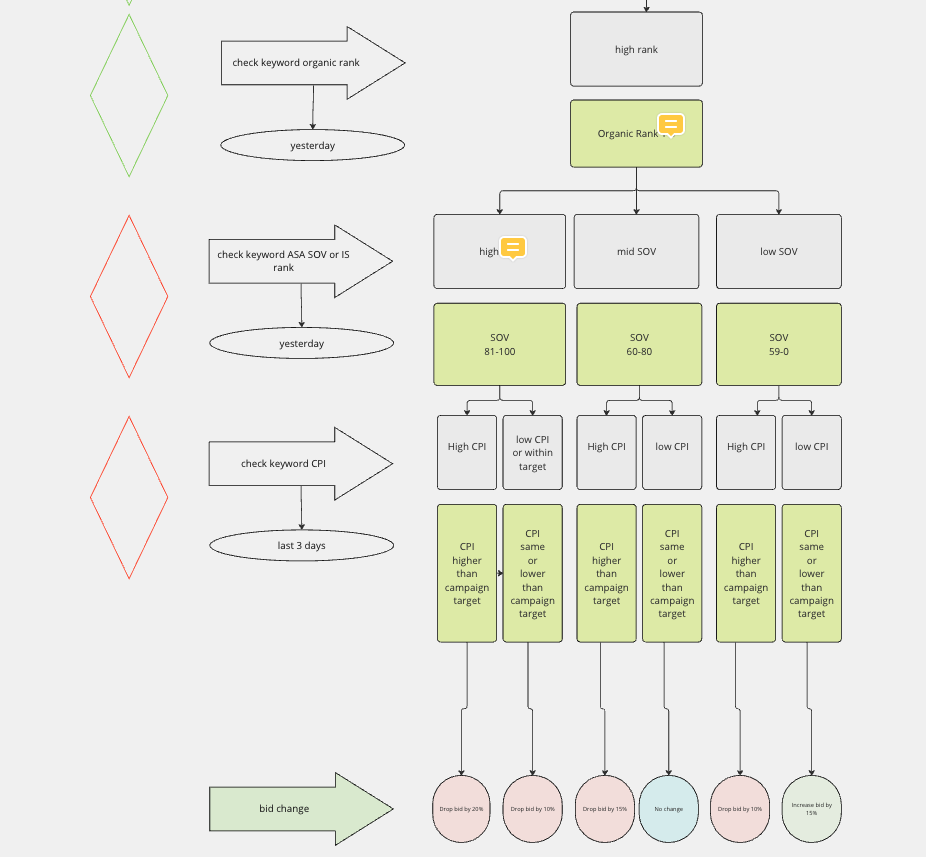
</div>

One of the values that influences the outcome of the decision tree is the **CPI Target**.

The CPI Target is a value unique for Phiture's ASA script. It is set on a campaign-level by Phiture's consultants to help control the campaigns spend and is used to decide whether a keyword bid should be dropped, increased or held. 

Info: 
- The CPI Target is selected by the consultants based on weekly campaign performance

I'll start by loading and exploring the data to understand its structure, features, and the target variable. This will help us in selecting the right preprocessing steps and model for prediction.

Here's an overview of the steps I will follow to build the model:

1. **Data Cleaning**: Handle missing values, irrelevant columns, and data types.
2. **Feature Engineering**: Extract relevant features and transform them if needed.
3. **Exploratory Data Analysis (EDA)**: Analyze the distribution of features and the relationship with the target variable.
4. **Data Splitting**: Split the dataset into training and testing subsets.
5. **Model Selection**: Choose a suitable machine learning model.
6. **Model Training**: Train the model on the training data.
7. **Model Evaluation**: Evaluate the model using the testing data.
8. **Model Tuning**: If needed, fine-tune the model parameters.


# Utils

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance


from google.oauth2 import service_account
from google.cloud import bigquery


from statsmodels.graphics.gofplots import qqplot

from sklearn.model_selection import learning_curve

from sklearn.model_selection import train_test_split

# PIPELINE AND COLUMNTRANSFORMER
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn import set_config; set_config(display="diagram")  

# IMPUTERS
from sklearn.impute import SimpleImputer

# SCALERS
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# ENCODER
from sklearn.preprocessing import OneHotEncoder

# LINEAR MODELS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

# NEIGHBORS
from sklearn.neighbors import KNeighborsRegressor

# SVM
from sklearn.svm import SVR

# TREES AND ENSEMBLE METHODS
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
#pd.set_option('display.max_columns', None)

from sklearn.model_selection import cross_val_score



In [5]:
# Create BQ credentials
client = bigquery.Client()

TODO: --> Explore SOV, Keyword count, average bid later. Perhaps the metrics available are enough to train the model.


# Load ASA scipt logs

project_id = 'bigqpr'
dataset_id = 'dw'

table_id = 'asa_bid_optimisation_log' 

query = f"""
        SELECT * FROM `{project_id}.{dataset_id}.{table_id}`
        WHERE date > '2023-04-01'
        """

query_job = client.query(query)

df_logs_raw = query_job.to_dataframe()


In [8]:
#df_logs_raw.to_csv("../raw_data/asa_bid_optimisation_log.csv", index=None)

df_logs_raw = pd.read_csv("../../raw_data/asa_bid_optimisation_log.csv", index_col=None)

/var/folders/t5/2vtmnxs90kx7flyvm9lmcfzm0000gn/T/ipykernel_42154/3972646279.py:3: DtypeWarning: Columns (20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df_logs_raw = pd.read_csv("../../raw_data/asa_bid_optimisation_log.csv", index_col=None)


# Load campaign level data from BQ

project_id = 'bigqpr'
dataset_id = 'adobe'

table_id = 'apple_asa_ios_app_campaigns' 

query = f"""
        SELECT * FROM `{project_id}.{dataset_id}.{table_id}`
        WHERE date > '2023-04-01'
        """

query_job = client.query(query)

df_bq_campaign_data = query_job.to_dataframe()


In [9]:
#df_bq_campaign_data.to_csv("../raw_data/df_bq_campaign_data.csv", index=None)

df_bq_campaign_data = pd.read_csv("../../raw_data/df_bq_campaign_data.csv", index_col=None)

In [10]:
df_bq_campaign_data.head()

,account_email,account_org_id,date,app_adam_id,campaign_id,campaign_name,countries_or_regions,currency,country_or_region,campaign_status,...,conversion_rate,installs,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,local_spend,taps,ttr
0,Phiture US,3631560,2023-07-29,1199564834,1417040621,CPP_ADOBE_SCAN_IN,IN,0,IN,PAUSED,...,0.7817,197,0,0.0,144,53,778,100.2139,252,0.3239
1,Phiture US,3631560,2023-07-29,331975235,1071033469,CPP_PHOTOSHOP_EXPRESS_US,US,0,US,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
2,Phiture US,3631560,2023-07-29,878783582,1086222658,CPP_ADOBE_LIGHTROOM_TH,TH,0,TH,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
3,Phiture US,3631560,2023-07-29,878783582,1086988277,CPP_ADOBE_LIGHTROOM_ID,ID,0,ID,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
4,Phiture US,3631560,2023-07-29,469337564,1098035365,CPP_ADOBE_ACROBAT_READER_US,US,0,US,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000


# Data Cleaning

In [11]:
df_logs_raw.head()

,app_global_id,app_name,country_code,locale_code,campaign_id,campaign_name,adgroup_id,keyword_id,toaster_keyword_id,word,...,organic_rank,share_of_voice,output_only,actions,log,overrides,keyword_last_modified,impressions,optimised,errors
0,469337564,Adobe Acrobat Reader,AR,es_mx,1259106861,CO-AR-CL-EC_Reader_ASA_Brand_EN_Q1,1259104195,1259106370,1638814.0,adobe pdf,...,1,NaN,False,"{""actions"":[""Rounded new bid: 0.234 -> 0.23"",""...","{""log"":[{""campaign_daily_budget"":30,""campaign_...","{""campaign"":{""constants.missing_sov_default"":95}}",2023-07-17,24,True,NaN
1,469337564,Adobe Acrobat Reader,AR,es_mx,1259106861,CO-AR-CL-EC_Reader_ASA_Brand_EN_Q1,1259104195,1259106366,1638818.0,adobe reader for ipad,...,4,NaN,False,"{""actions"":[""Rounded new bid: 0.22799999999999...","{""log"":[{""campaign_daily_budget"":30,""campaign_...","{""campaign"":{""constants.missing_sov_default"":95}}",2023-07-17,0,True,NaN
2,469337564,Adobe Acrobat Reader,AR,es_mx,1259106861,CO-AR-CL-EC_Reader_ASA_Brand_EN_Q1,1259104195,1259106365,1638819.0,adobe reader for iphone,...,7,NaN,False,"{""actions"":[""Rounded new bid: 0.247 -> 0.25"",""...","{""log"":[{""campaign_daily_budget"":30,""campaign_...","{""campaign"":{""constants.missing_sov_default"":95}}",2023-07-17,0,True,NaN
3,469337564,Adobe Acrobat Reader,AR,es_mx,1259106861,CO-AR-CL-EC_Reader_ASA_Brand_EN_Q1,1259104195,1259106364,1638820.0,adobe reader,...,1,NaN,False,"{""actions"":[""Increased calculated bid due to l...","{""log"":[{""campaign_daily_budget"":30,""campaign_...","{""campaign"":{""constants.missing_sov_default"":95}}",2023-07-17,238,True,NaN
4,469337564,Adobe Acrobat Reader,AR,es_mx,1258717500,CO-AR-CL-EC_Reader_ASA_Generic_ES-EN_Q1,1259106020,1259123730,1638927.0,escribir en pdf,...,1,NaN,False,"{""actions"":[""Increased calculated bid due to l...","{""log"":[{""campaign_daily_budget"":80,""campaign_...","{""campaign"":{""constants.max_bid_cap"":8,""consta...",2023-06-26,1,True,NaN


In [12]:
df_logs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459824 entries, 0 to 459823
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   app_global_id          459824 non-null  int64  
 1   app_name               459824 non-null  object 
 2   country_code           459824 non-null  object 
 3   locale_code            459824 non-null  object 
 4   campaign_id            459824 non-null  int64  
 5   campaign_name          459824 non-null  object 
 6   adgroup_id             459824 non-null  int64  
 7   keyword_id             459824 non-null  int64  
 8   toaster_keyword_id     336247 non-null  float64
 9   word                   459824 non-null  object 
 10  date                   459824 non-null  object 
 11  old_bid_amount         459824 non-null  float64
 12  new_bid_amount         149897 non-null  float64
 13  cpi                    459824 non-null  float64
 14  target_cpi             459824 non-nu

In [13]:
df_logs_raw["date_dt"] = pd.to_datetime(df_logs_raw["date"])

In [14]:
print(df_logs_raw[(df_logs_raw["keyword_id"]==1259126217) &
           (df_logs_raw["date_dt"] == "2023-07-21")]["log"].iloc[0])

{"log":[{"campaign_daily_budget":235,"campaign_pacing":0.9,"campaign_spending_yesterday":232.6776,"override":null,"path":"campaign_overspend"},{"keyword_organic_rank":20,"override":null,"path":"campaign_overspend.keyword_rank_low"},{"default_sov_used":false,"override":null,"path":"campaign_overspend.keyword_rank_low.share_of_voice_low","share_of_voice":25,"sov_date":"2023-07-19"},{"cpi":0.7117833333333333,"override":null,"path":"campaign_overspend.keyword_rank_low.share_of_voice_low.cpi_low","target_cpi":0.75},{"bid_modifier":1.1,"current_bid":0.91,"new_bid":1.0010000000000001,"override":null,"path":"campaign_overspend.keyword_rank_low.share_of_voice_low.cpi_low.bid_modifier"}]}


## Dataset description

Data granularity = Daily

- app_global_id : App id
- app_name : App name
- country_code : country 
- locale_code : locale code
- campaign_id : id of ASA campaign
- campaign_name : Name of ASA campaign
- adgroup_id : Id of adgroup
- keyword_id : Id of keyword
- toaster_keyword_id : Id of keyword in toaster
- word : keyword
- date : day
- old_bid_amount : ASA bid amount on date
- new_bid_amount : New ASA bid amount after decision tree
- cpi :Cost-per-install
- target_cpi :
- installs :
- spend :
- organic_rank :
- share_of_voice :
- output_only :
- actions :
- log :
- overrides :
- keyword_last_modified :
- impressions :
- optimised :
- errors :

## Check and remove duplicate rows

In [18]:
duplicate_count = len(df_logs_raw) - len(df_logs_raw.drop_duplicates()) 

# Original data length minus data length without duplicates
duplicate_count

717

In [19]:
# check if all keywords have ids
df_logs_raw["keyword_id"].isnull().sum()

0

In [20]:
# check if any campaign_ids are missing
df_logs_raw["campaign_id"].isnull().sum()

0

In [21]:
# view duplicate rows
df_logs_raw[df_logs_raw.duplicated(keep=False )].sort_values(by=["date", "toaster_keyword_id"])


,app_global_id,app_name,country_code,locale_code,campaign_id,campaign_name,adgroup_id,keyword_id,toaster_keyword_id,word,...,share_of_voice,output_only,actions,log,overrides,keyword_last_modified,impressions,optimised,errors,date_dt
309276,1199564834,Adobe Scan,JP,ja_jp,1258769761,JP_Scan_ASA_Generic_EN-JP_Q1,1258762374,1258769691,935721.0,pdf scanner,...,NaN,False,NaN,"{""log"":[{""campaign_daily_budget"":100,""campaign...","{""campaign"":{""constants.max_bid_cap"":6}}",2023-05-05,0,False,NaN,2023-05-09
309277,1199564834,Adobe Scan,JP,ja_jp,1258769761,JP_Scan_ASA_Generic_EN-JP_Q1,1258762374,1258769691,935721.0,pdf scanner,...,NaN,False,NaN,"{""log"":[{""campaign_daily_budget"":100,""campaign...","{""campaign"":{""constants.max_bid_cap"":6}}",2023-05-05,0,False,NaN,2023-05-09
303373,1199564834,Adobe Scan,JP,ja_jp,1258769761,JP_Scan_ASA_Generic_EN-JP_Q1,1258765890,1258772750,952238.0,かめら,...,NaN,False,NaN,"{""log"":[{""campaign_daily_budget"":100,""campaign...","{""campaign"":{""constants.max_bid_cap"":6}}",2023-05-05,0,False,NaN,2023-05-09
303374,1199564834,Adobe Scan,JP,ja_jp,1258769761,JP_Scan_ASA_Generic_EN-JP_Q1,1258765890,1258772750,952238.0,かめら,...,NaN,False,NaN,"{""log"":[{""campaign_daily_budget"":100,""campaign...","{""campaign"":{""constants.max_bid_cap"":6}}",2023-05-05,0,False,NaN,2023-05-09
309435,1199564834,Adobe Scan,JP,ja_jp,1258769761,JP_Scan_ASA_Generic_EN-JP_Q1,1258768707,1258770747,963795.0,doc scanner,...,NaN,False,NaN,"{""log"":[{""campaign_daily_budget"":100,""campaign...","{""campaign"":{""constants.max_bid_cap"":6}}",2023-05-05,0,False,NaN,2023-05-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309147,469337564,Adobe Acrobat Reader,IT,it,1260513992,IT_Reader_ASA_Discovery_IT-EN_Q1,1260740925,1261653951,NaN,acrobat reader for ipad,...,NaN,False,NaN,"{""log"":[{""status"":""Unranked keyword. Set organ...",NaN,2023-05-03,0,False,NaN,2023-05-09
309148,469337564,Adobe Acrobat Reader,IT,it,1260513992,IT_Reader_ASA_Discovery_IT-EN_Q1,1260740925,1261653952,NaN,acrobat reader for iphone,...,NaN,False,NaN,"{""log"":[{""status"":""Unranked keyword. Set organ...",NaN,2023-05-03,0,False,NaN,2023-05-09
309149,469337564,Adobe Acrobat Reader,IT,it,1260513992,IT_Reader_ASA_Discovery_IT-EN_Q1,1260740925,1261653952,NaN,acrobat reader for iphone,...,NaN,False,NaN,"{""log"":[{""status"":""Unranked keyword. Set organ...",NaN,2023-05-03,0,False,NaN,2023-05-09
309150,469337564,Adobe Acrobat Reader,IT,it,1260513992,IT_Reader_ASA_Discovery_IT-EN_Q1,1260740925,1261653953,NaN,acrobat pro dc,...,NaN,False,NaN,"{""log"":[{""status"":""Unranked keyword. Set organ...",NaN,2023-05-03,0,False,NaN,2023-05-09


In [22]:
df_logs_raw.drop_duplicates(inplace=True) # Drop duplicates in place


## Missing data

In [23]:
# percentage of missing data per column
round(df_logs_raw.isnull().sum().sort_values(ascending=False)/len(df_logs_raw),2) #NaN percentage for each column


errors                   1.00
share_of_voice           0.86
actions                  0.67
new_bid_amount           0.67
overrides                0.38
toaster_keyword_id       0.27
app_global_id            0.00
installs                 0.00
optimised                0.00
impressions              0.00
keyword_last_modified    0.00
log                      0.00
output_only              0.00
organic_rank             0.00
spend                    0.00
target_cpi               0.00
app_name                 0.00
cpi                      0.00
old_bid_amount           0.00
date                     0.00
word                     0.00
keyword_id               0.00
adgroup_id               0.00
campaign_name            0.00
campaign_id              0.00
locale_code              0.00
country_code             0.00
date_dt                  0.00
dtype: float64

In [24]:
# check overrides
for log in df_logs_raw[~df_logs_raw["overrides"].isnull()]["overrides"].unique():
    
    print(log)

{"campaign":{"constants.missing_sov_default":95}}
{"campaign":{"constants.max_bid_cap":8,"constants.missing_sov_default":95}}
{"campaign":{"constants.max_bid_cap":6,"constants.missing_sov_default":95}}
{"campaign":{"constants.max_bid_cap":15}}
{"campaign":{"constants.max_bid_cap":8}}
{"campaign":{"constants.max_bid_cap":6}}
{"app":{"constants.modify_bid_cutoff_days":0}}
{"campaign":{"constants.max_bid_cap":4,"constants.max_cpi":1.5,"constants.max_cpi_bid_modifier":0.6,"constants.missing_sov_default":95}}
{"campaign":{"constants.max_bid_cap":5,"constants.max_cpi":1.5,"constants.max_cpi_bid_modifier":0.6,"constants.missing_sov_default":95}}
{"campaign":{"constants.max_cpi":1.5,"constants.max_cpi_bid_modifier":0.6,"constants.missing_sov_default":95}}
{"campaign":{"constants.max_cpi":1.5,"constants.max_cpi_bid_modifier":0.6}}
{"campaign":{"constants.max_bid_cap":8,"constants.missing_sov_default":85}}
{"campaign":{"constants.max_bid_cap":6,"constants.missing_sov_default":85}}
{"campaign":{"

In [25]:
# drop error, actions, toaster_keyword_id, and overrides
df_logs_raw.drop(columns=["errors",
                   "actions",
                   "toaster_keyword_id",
                   "overrides"], inplace=True) # Drop ChimneyStyle column 


In [26]:
# impute missing share of voice with 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # Instanciate a SimpleImputer object with strategy of choice

imputer.fit(df_logs_raw[['share_of_voice']]) # Call the "fit" method on the object

df_logs_raw['share_of_voice'] = imputer.transform(df_logs_raw[['share_of_voice']]) # Call the "transform" method on the object



In [27]:
round(df_logs_raw.isnull().sum().sort_values(ascending=False)/len(df_logs_raw),2) #NaN percentage for each column

# create a column called bid changes - and bid diff then drop new_bid ammount


new_bid_amount           0.67
app_global_id            0.00
target_cpi               0.00
optimised                0.00
impressions              0.00
keyword_last_modified    0.00
log                      0.00
output_only              0.00
share_of_voice           0.00
organic_rank             0.00
spend                    0.00
installs                 0.00
cpi                      0.00
app_name                 0.00
old_bid_amount           0.00
date                     0.00
word                     0.00
keyword_id               0.00
adgroup_id               0.00
campaign_name            0.00
campaign_id              0.00
locale_code              0.00
country_code             0.00
date_dt                  0.00
dtype: float64

In [28]:
df_logs_raw["bid_changed"] = df_logs_raw["new_bid_amount"].apply(lambda x: False if np.isnan(x) else True)

In [29]:
# check - if bid changed. is False then sum of new_bids should be 0
df_logs_raw[df_logs_raw["bid_changed"] == False][["old_bid_amount", "new_bid_amount", "bid_changed"]].sum()

old_bid_amount    2161729.54
new_bid_amount          0.00
bid_changed             0.00
dtype: float64

In [30]:
df_logs_raw["bid_diff"] = df_logs_raw["new_bid_amount"] - df_logs_raw["old_bid_amount"]
df_logs_raw["bid_diff"].fillna(0, inplace=True)

In [31]:
df_logs_raw[df_logs_raw["bid_changed"] == False][["old_bid_amount", "new_bid_amount", "bid_changed", "bid_diff"]]

,old_bid_amount,new_bid_amount,bid_changed,bid_diff
547,0.06,NaN,False,0.0
548,8.00,NaN,False,0.0
549,8.00,NaN,False,0.0
550,3.83,NaN,False,0.0
551,8.00,NaN,False,0.0
...,...,...,...,...
459819,10.00,NaN,False,0.0
459820,10.00,NaN,False,0.0
459821,10.00,NaN,False,0.0
459822,10.00,NaN,False,0.0


In [32]:
def fill_new_bid_amount(old_bid, new_bid):
    
    if np.isnan(new_bid):
        return old_bid
    
    return new_bid

In [33]:
df_logs_raw["old_bid_amount"]

0          0.26
1          0.24
2          0.26
3          0.19
4          0.05
          ...  
459819    10.00
459820    10.00
459821    10.00
459822    10.00
459823    10.00
Name: old_bid_amount, Length: 459107, dtype: float64

In [34]:
df_logs_raw["new_bid_amount"] = df_logs_raw.apply(lambda x: fill_new_bid_amount(x["old_bid_amount"], x["new_bid_amount"]), axis=1)

In [35]:
#How many locales and countries are there?
print("countries")
print(df_logs_raw["country_code"].nunique())
print(df_logs_raw["country_code"].value_counts())


print("locales")
print(df_logs_raw["locale_code"].nunique())
print(df_logs_raw["locale_code"].value_counts())


countries
8
country_code
MX    101586
IT     99053
JP     75028
IN     58707
KR     50293
AR     46793
CH     13962
HK     13685
Name: count, dtype: int64
locales
7
locale_code
es_mx    148379
it        99053
ja_jp     75028
en_gb     58707
ko_kr     50293
de_ch     13962
zh_hk     13685
Name: count, dtype: int64


In [36]:
# remove spaces 
df_logs_raw["country_code"] = df_logs_raw["country_code"].map(str.strip)

## Campaign level data from BQ

In [37]:
df_bq_campaign_data.head()

,account_email,account_org_id,date,app_adam_id,campaign_id,campaign_name,countries_or_regions,currency,country_or_region,campaign_status,...,conversion_rate,installs,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,local_spend,taps,ttr
0,Phiture US,3631560,2023-07-29,1199564834,1417040621,CPP_ADOBE_SCAN_IN,IN,0,IN,PAUSED,...,0.7817,197,0,0.0,144,53,778,100.2139,252,0.3239
1,Phiture US,3631560,2023-07-29,331975235,1071033469,CPP_PHOTOSHOP_EXPRESS_US,US,0,US,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
2,Phiture US,3631560,2023-07-29,878783582,1086222658,CPP_ADOBE_LIGHTROOM_TH,TH,0,TH,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
3,Phiture US,3631560,2023-07-29,878783582,1086988277,CPP_ADOBE_LIGHTROOM_ID,ID,0,ID,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
4,Phiture US,3631560,2023-07-29,469337564,1098035365,CPP_ADOBE_ACROBAT_READER_US,US,0,US,PAUSED,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000


In [38]:
# Missing values
round(df_bq_campaign_data.isnull().sum().sort_values(ascending=False)/len(df_bq_campaign_data),2) #NaN percentage for each column


serving_state_reasons     0.18
account_email             0.00
total_budget              0.00
taps                      0.00
local_spend               0.00
impressions               0.00
installs_redownloads      0.00
installs_new_downloads    0.00
lat_off_installs          0.00
lat_on_installs           0.00
installs                  0.00
conversion_rate           0.00
avg_cpt                   0.00
avg_cpa                   0.00
other                     0.00
daily_budget              0.00
account_org_id            0.00
deleted                   0.00
serving_status            0.00
modification_time         0.00
display_status            0.00
campaign_status           0.00
country_or_region         0.00
currency                  0.00
countries_or_regions      0.00
campaign_name             0.00
campaign_id               0.00
app_adam_id               0.00
date                      0.00
ttr                       0.00
dtype: float64

In [39]:
# change column to date type
df_bq_campaign_data["date_dt"] = pd.to_datetime(df_bq_campaign_data["date"])
df_bq_campaign_data["country_code"] = df_bq_campaign_data["country_or_region"].map(str.strip)

In [40]:
df_bq_campaign_data_clean = df_bq_campaign_data[['date_dt', 'app_adam_id', 'campaign_id',
       'campaign_name', 'currency',
       'country_code', 'campaign_status', 'display_status',
       'modification_time', 'serving_status',
       'deleted', 'daily_budget', 'total_budget', 'other', 'avg_cpa',
       'avg_cpt', 'conversion_rate', 'installs', 'lat_on_installs',
       'lat_off_installs', 'installs_new_downloads', 'installs_redownloads',
       'impressions', 'local_spend', 'taps', 'ttr']]

In [41]:
df_bq_campaign_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119049 entries, 0 to 119048
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date_dt                 119049 non-null  datetime64[ns]
 1   app_adam_id             119049 non-null  int64         
 2   campaign_id             119049 non-null  int64         
 3   campaign_name           119049 non-null  object        
 4   currency                119049 non-null  object        
 5   country_code            119049 non-null  object        
 6   campaign_status         119049 non-null  object        
 7   display_status          119049 non-null  object        
 8   modification_time       119049 non-null  object        
 9   serving_status          119049 non-null  object        
 10  deleted                 119049 non-null  bool          
 11  daily_budget            119049 non-null  float64       
 12  total_budget            119049

# Aggregate Log Data to Campaign Level

In [42]:
df_logs_raw.columns

Index(['app_global_id', 'app_name', 'country_code', 'locale_code',
       'campaign_id', 'campaign_name', 'adgroup_id', 'keyword_id', 'word',
       'date', 'old_bid_amount', 'new_bid_amount', 'cpi', 'target_cpi',
       'installs', 'spend', 'organic_rank', 'share_of_voice', 'output_only',
       'log', 'keyword_last_modified', 'impressions', 'optimised', 'date_dt',
       'bid_changed', 'bid_diff'],
      dtype='object')

group by
- app_name,
- country_code,
- date_dt,
- campaign_id,
- campaign_name,
- target_cpi,
- count keyword_id,

- sum impressions,
- sum installs,
- sum spend,
- avg organic_rank
- avg share of voice


In [43]:
# check unique cpi targets

In [44]:
df_logs_raw.groupby(["campaign_id", "date_dt", "country_code"]).nunique()["target_cpi"].value_counts()

target_cpi
1    3062
Name: count, dtype: int64

In [45]:
df_logs_raw.groupby(["campaign_id", "date_dt"]).nunique()["target_cpi"].value_counts()

target_cpi
1    3062
Name: count, dtype: int64

In [46]:
df_logs_raw.groupby(["campaign_id", "country_code"]).nunique()["target_cpi"].value_counts()

target_cpi
5    7
3    6
2    6
6    5
8    4
7    3
4    2
9    1
Name: count, dtype: int64

In [47]:
# CPI targets are unique at the campaign and date level

group_columns = [
                "app_name",
                "country_code",
                "campaign_id",
                "campaign_name",
                "date_dt"
                ]

In [48]:
# proportion of high ranking words
# proportion of low ranking words
# proportion of keywords with high SOV
# daily budget --> where can I find it?

df_campaign_daily = df_logs_raw.groupby(group_columns).aggregate({'target_cpi': ['max', 'min', 'mean'],
                                              'keyword_id': 'nunique',
                                             'impressions': 'sum',
                                             'installs': 'sum',
                                             'spend': 'sum',
                                             'organic_rank': 'mean',
                                             'share_of_voice': 'mean',
                                             'old_bid_amount': 'mean'}).reset_index()

df_campaign_daily.head()

app_name country_code campaign_id  \
                                                   
0  Adobe Acrobat Reader           AR  1258717500   
1  Adobe Acrobat Reader           AR  1258717500   
2  Adobe Acrobat Reader           AR  1258717500   
3  Adobe Acrobat Reader           AR  1258717500   
4  Adobe Acrobat Reader           AR  1258717500   

                             campaign_name    date_dt target_cpi              \
                                                             max   min  mean   
0  CO-AR-CL-EC_Reader_ASA_Generic_ES-EN_Q1 2023-04-02       0.45  0.45  0.45   
1  CO-AR-CL-EC_Reader_ASA_Generic_ES-EN_Q1 2023-04-03       0.45  0.45  0.45   
2  CO-AR-CL-EC_Reader_ASA_Generic_ES-EN_Q1 2023-04-04       0.45  0.45  0.45   
3  CO-AR-CL-EC_Reader_ASA_Generic_ES-EN_Q1 2023-04-05       0.45  0.45  0.45   
4  CO-AR-CL-EC_Reader_ASA_Generic_ES-EN_Q1 2023-04-06       0.45  0.45  0.45   

  keyword_id impressions installs  spend organic_rank share_of_voice  \
     nunique         sum      sum    sum         mean           mean   
0        159         283       66  50.68    82.062893           70.0   
1        159         482       59  61.06    82.062893           70.0   
2        159         570       77  70.75    80.591195           70.0   
3        159         274       47  35.52    80.509434           70.0   
4        159         259       50  33.80    79.044025           70.0   

  old_bid_amount  
            mean  
0       4.752642  
1       4.779371  
2       4.765094  
3       4.774025  
4       4.816918

In [49]:
# list all campaign ids
df_campaign_daily.columns = list(map('_'.join, df_campaign_daily.columns.values))

In [50]:
df_campaign_daily.columns

Index(['app_name_', 'country_code_', 'campaign_id_', 'campaign_name_',
       'date_dt_', 'target_cpi_max', 'target_cpi_min', 'target_cpi_mean',
       'keyword_id_nunique', 'impressions_sum', 'installs_sum', 'spend_sum',
       'organic_rank_mean', 'share_of_voice_mean', 'old_bid_amount_mean'],
      dtype='object')

In [51]:
df_campaign_daily.columns = ['app_name', 'country_code', 'campaign_id', 'campaign_name',
       'date_dt', 'target_cpi_max', 'target_cpi_min', 'target_cpi_mean',
       'keyword_id_nunique', 'impressions_sum', 'installs_sum', 'spend_sum',
       'organic_rank_mean', 'share_of_voice_mean', 'old_bid_amount_mean']

In [52]:
df_campaign_daily.shape

(3062, 15)

In [53]:
df_campaign_target_daily = df_campaign_daily[["country_code", "app_name", "campaign_id", "campaign_name", "date_dt", "target_cpi_mean"]].copy()



In [54]:
df_bq_campaign_data_clean.head(1)

,date_dt,app_adam_id,campaign_id,campaign_name,currency,country_code,campaign_status,display_status,modification_time,serving_status,...,conversion_rate,installs,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,local_spend,taps,ttr
0,2023-07-29,1199564834,1417040621,CPP_ADOBE_SCAN_IN,0,IN,PAUSED,PAUSED,2023-08-02 08:09:07.493,NOT_RUNNING,...,0.7817,197,0,0.0,144,53,778,100.2139,252,0.3239


In [55]:
df_campaign_target_daily.head(1)

,country_code,app_name,campaign_id,campaign_name,date_dt,target_cpi_mean
0,AR,Adobe Acrobat Reader,1258717500,CO-AR-CL-EC_Reader_ASA_Generic_ES-EN_Q1,2023-04-02,0.45


In [56]:
df_bq_campaign_data_clean[df_bq_campaign_data_clean["campaign_status"]=="ENABLED"]

,date_dt,app_adam_id,campaign_id,campaign_name,currency,country_code,campaign_status,display_status,modification_time,serving_status,...,conversion_rate,installs,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,local_spend,taps,ttr
342,2023-07-29,469337564,542518068,IT_READER_BRAND_GENERAL_APPLE_EN,0,IT,ENABLED,ON_HOLD,2023-07-06 22:11:27.408,NOT_RUNNING,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
343,2023-07-29,878783582,1177278284,NA - Lightroom - iPhone - Product Page,0,US,ENABLED,ON_HOLD,2022-12-22 22:39:32.595,NOT_RUNNING,...,0.0000,0,0,0.0,0,0,0,0.0000,0,0.0000
344,2023-07-29,1199564834,1072674563,CA_SCAN_BRAND_GENERAL_APPLE_New,0,CA,ENABLED,RUNNING,2023-07-11 15:07:44.406,RUNNING,...,0.8261,19,0,0.0,15,4,46,17.0383,23,0.5000
345,2023-07-29,1199564834,1241119920,JP_SCAN_BRAND_GENERAL_APPLE_New,0,JP,ENABLED,RUNNING,2023-07-28 14:59:12.935,RUNNING,...,0.7091,39,0,0.0,30,9,288,31.1272,55,0.1910
346,2023-07-29,1199564834,1241733689,IT_SCAN_BRAND_GENERAL_APPLE_New,0,IT,ENABLED,RUNNING,2023-07-11 15:09:46.591,RUNNING,...,0.7000,14,0,0.0,13,1,53,18.8826,20,0.3774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119044,2023-05-30,804177739,105297130,AU - Lightroom - iPad - Brand - Exact,USD,AU,ENABLED,RUNNING,2023-05-11 20:36:05.351,RUNNING,...,0.7037,19,0,0.0,16,3,97,19.8558,27,0.2784
119045,2023-05-30,878783582,490824967,TH - Lightroom - iPhone - Brand - Exact,USD,TH,ENABLED,RUNNING,2023-05-30 17:13:45.326,RUNNING,...,0.8498,532,0,0.0,262,270,1573,86.9664,626,0.3980
119046,2023-05-30,804177739,282644739,KR - Lightroom - iPad - Brand - Exact,USD,KR,ENABLED,RUNNING,2023-03-24 23:38:17.318,RUNNING,...,0.6047,26,0,0.0,20,6,333,19.0587,43,0.1291
119047,2023-05-30,878783582,105341661,NZ - Lightroom - iPhone - Brand - Exact,USD,NZ,ENABLED,RUNNING,2023-05-30 21:15:10.464,RUNNING,...,0.8462,33,0,0.0,15,18,110,31.6469,39,0.3545


In [57]:
df_bq_campaign_data_clean.shape

(119049, 26)

In [58]:
df_campaign_target_daily.shape

(3062, 6)

# Merge aggregated log data with campaign level data

In [59]:
df_merged = pd.merge(df_bq_campaign_data_clean,
         df_campaign_target_daily,
         on=["date_dt",
             "campaign_id",
             "country_code",
             "campaign_name"],
         how='inner')


In [60]:
## all campaigns with CPI targets were found

In [61]:
sum(df_merged["target_cpi_mean"].isnull())

0

In [62]:
df_merged.columns

Index(['date_dt', 'app_adam_id', 'campaign_id', 'campaign_name', 'currency',
       'country_code', 'campaign_status', 'display_status',
       'modification_time', 'serving_status', 'deleted', 'daily_budget',
       'total_budget', 'other', 'avg_cpa', 'avg_cpt', 'conversion_rate',
       'installs', 'lat_on_installs', 'lat_off_installs',
       'installs_new_downloads', 'installs_redownloads', 'impressions',
       'local_spend', 'taps', 'ttr', 'app_name', 'target_cpi_mean'],
      dtype='object')

In [63]:
df_merged[['date_dt', 'campaign_id', 'campaign_name', 'avg_cpa', 'avg_cpt', 'conversion_rate',
       'installs', 'impressions',
       'local_spend', 'taps', 'target_cpi_mean']].head()

,date_dt,campaign_id,campaign_name,avg_cpa,avg_cpt,conversion_rate,installs,impressions,local_spend,taps,target_cpi_mean
0,2023-07-29,1420477419,CH_Reader_ASA_Discovery_EN-DE-FR_Q1,0.5451,0.3730,0.6842,13,378,7.0861,19,0.50
1,2023-07-29,1420565694,CH_Reader_ASA_Generic_EN-DE-FR_Q1,1.4656,0.4885,0.3333,2,67,2.9311,6,0.40
2,2023-07-29,1259027528,IN_Reader_ASA_Generic_EN_Q1,0.3282,0.2513,0.7656,712,4258,233.6651,930,0.75
3,2023-07-29,1259038153,IN_Reader_ASA_Discovery_EN_Q1,0.4909,0.2270,0.4624,473,16740,232.1870,1023,0.80
4,2023-07-29,1259106501,IN_Reader_ASA_Brand_EN_Q1,0.1950,0.1555,0.7971,389,1124,75.8654,488,0.70


In [64]:
# annonymize data
import uuid


campaign_ids = df_merged["campaign_id"].unique()
campaign_names = df_merged["campaign_name"].unique()
app_names = df_merged["app_name"].unique()

c_id_dict = {}
c_name_dict = {}
app_name_dict = {}


for c_id in campaign_ids:
    new_id = str(uuid.uuid4())
    c_id_dict[c_id] = new_id
    


for c_name in campaign_names:
    new_c_name = str(uuid.uuid4())
    c_name_dict[c_name] = new_c_name
    


for app_name in app_names:
    new_app_name = str(uuid.uuid4())
    app_name_dict[app_name] = new_app_name
    
    
    

In [65]:
#df_moc.to_csv("../raw_data/df_moc.csv")

# EDA

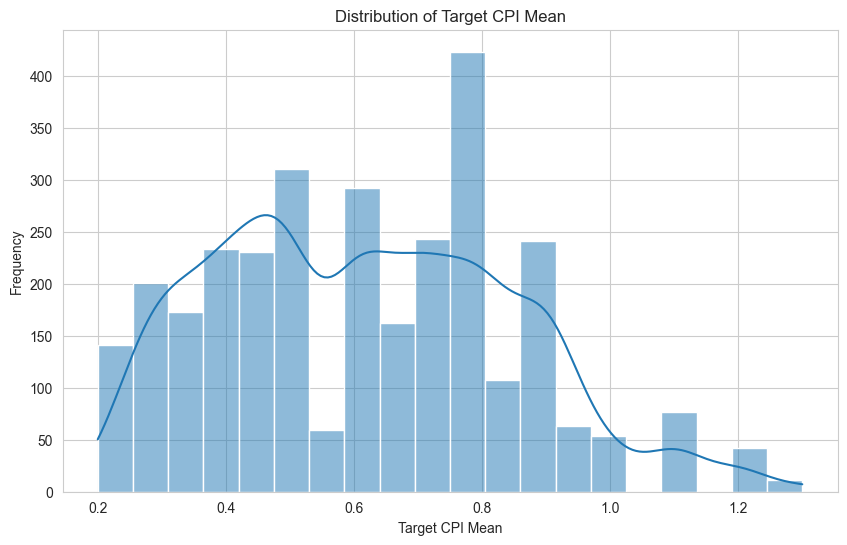

In [66]:
# view target variable


# Setting the plot style
sns.set_style("whitegrid")

# Plotting the distribution of the target variable 'target_cpi_mean'
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['target_cpi_mean'], bins=20, kde=True)
plt.title('Distribution of Target CPI Mean')
plt.xlabel('Target CPI Mean')
plt.ylabel('Frequency')
plt.show()

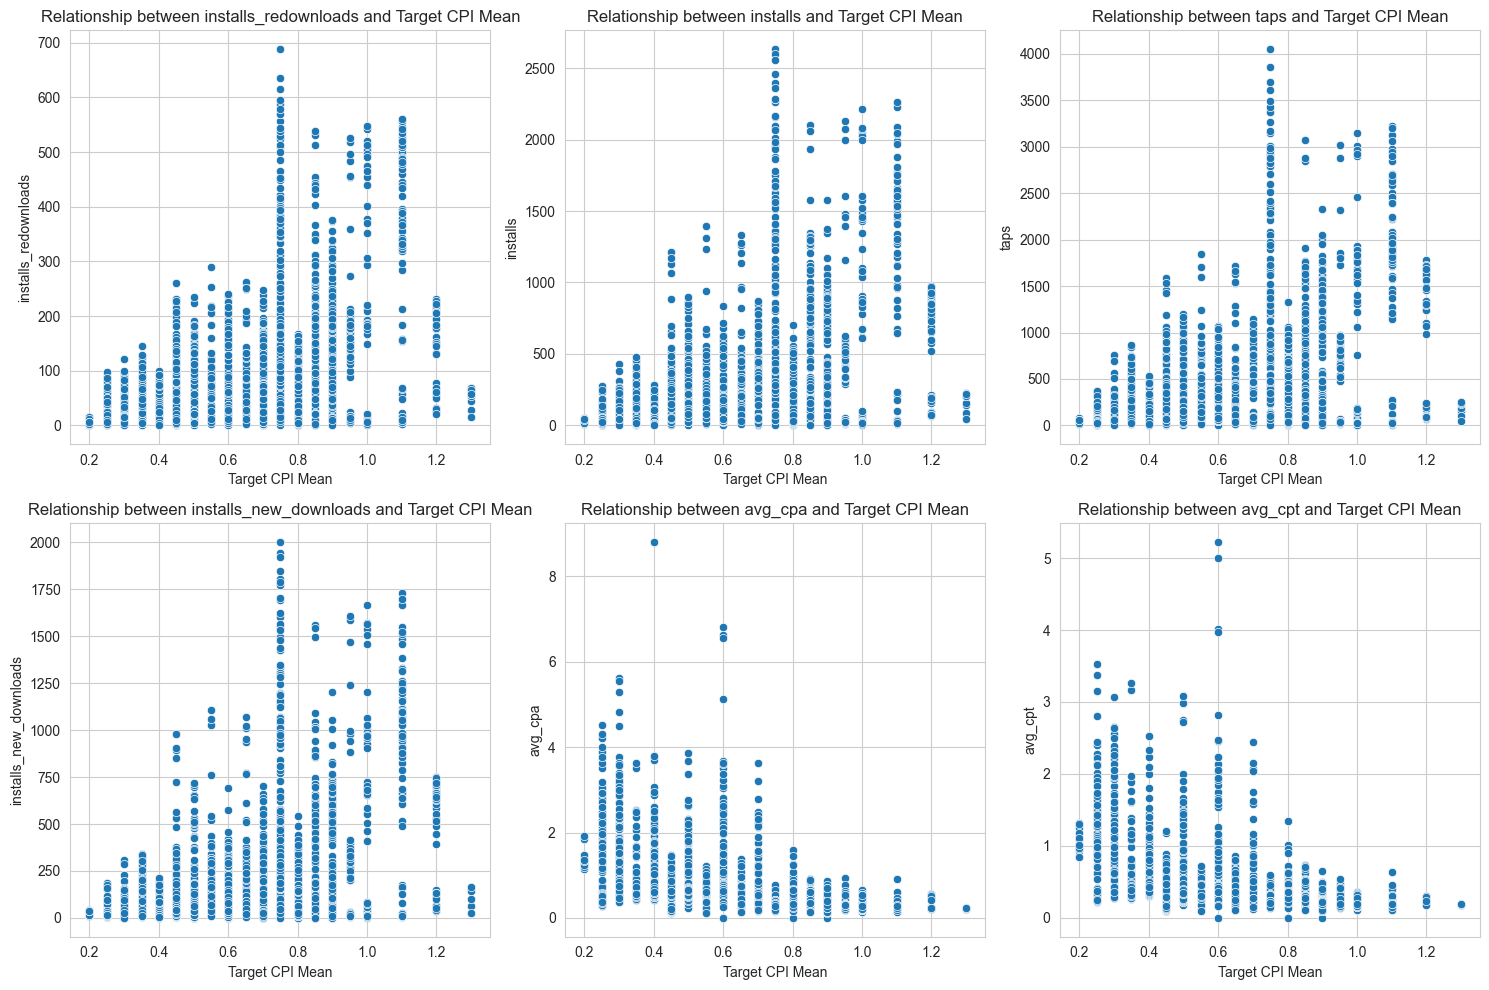

In [67]:
# Selecting the key numerical features for visualization
numerical_features = ['installs_redownloads', 
                      'installs',
                      'taps',
                      'installs_new_downloads',
                      'avg_cpa', 'avg_cpt']

# Plotting scatter plots to visualize the relationship between the numerical features and target_cpi_mean
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(y=df_merged[feature], x=df_merged['target_cpi_mean'])
    plt.title(f'Relationship between {feature} and Target CPI Mean')
    plt.ylabel(feature)
    plt.xlabel('Target CPI Mean')

plt.tight_layout()
plt.show()


Certainly! Let's explore the relationship between some key categorical features and the target variable `target_cpi_mean`. This will help us understand how different categories within these features influence the target variable.

We'll focus on the following categorical features:
- `country_code`: To analyze how the target CPI mean varies across different countries.
- `campaign_status`: To understand the effect of campaign status (e.g., Enabled, Disabled) on the target CPI mean.

We'll create bar plots to visualize these relationships.

Starting with the `country_code`, let's visualize how the target CPI mean varies across different countries. Shall we?



/var/folders/t5/2vtmnxs90kx7flyvm9lmcfzm0000gn/T/ipykernel_42154/2788072851.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='country_code', y='target_cpi_mean', data=df_merged, ci=None)


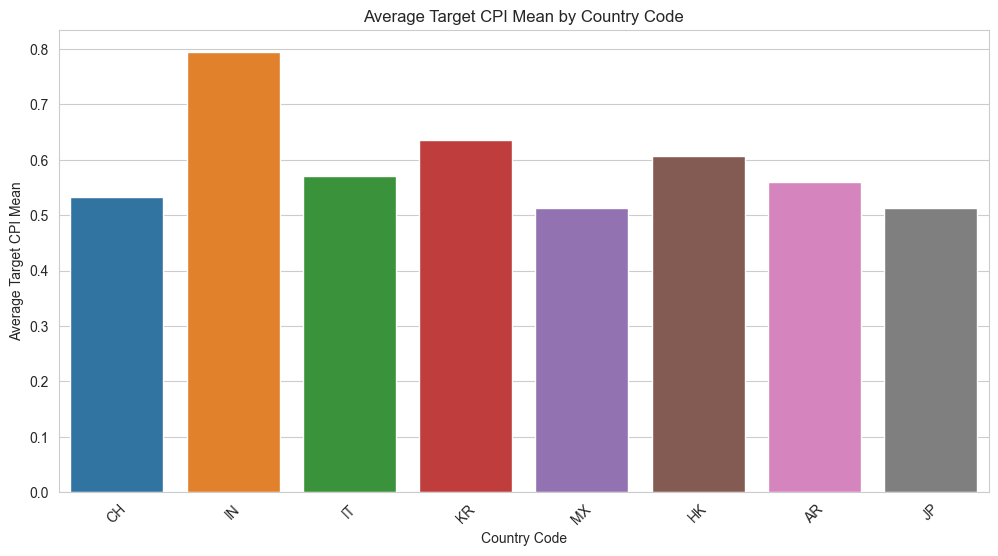

In [68]:
# Plotting the average target_cpi_mean for different country codes
plt.figure(figsize=(12, 6))
sns.barplot(x='country_code', y='target_cpi_mean', data=df_merged, ci=None)
plt.title('Average Target CPI Mean by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Average Target CPI Mean')
plt.xticks(rotation=45)
plt.show()


The bar plot illustrates the average `target_cpi_mean` for different country codes. We can see that the target CPI mean varies across countries, indicating that the country code might be an influential feature in predicting the target CPI mean.

Next, let's visualize the relationship between `campaign_status` and the target variable `target_cpi_mean` to understand how the status of a campaign might affect the target CPI mean.

Shall we proceed with this visualization?



The bar plot illustrates the average `target_cpi_mean` for different campaign statuses. Since all the campaigns in this dataset are labeled as "ENABLED," we don't have variations in the campaign status to analyze further.

With these visualizations, we have gained insights into the relationships between key features and the target variable, `target_cpi_mean`. These insights will be valuable in feature selection and model building.

We can now proceed to the following steps:
1. **Data Splitting**: Divide the data into training and testing sets.
2. **Model Selection**: Choose an appropriate machine learning model.
3. **Model Training**: Train the model on the training data.
4. **Model Evaluation**: Evaluate the model using the testing data.

Shall we move on to these steps?

# Model Building & Feature Scaling

In [69]:
df_merged.head()

,date_dt,app_adam_id,campaign_id,campaign_name,currency,country_code,campaign_status,display_status,modification_time,serving_status,...,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,local_spend,taps,ttr,app_name,target_cpi_mean
0,2023-07-29,469337564,1420477419,CH_Reader_ASA_Discovery_EN-DE-FR_Q1,0,CH,ENABLED,RUNNING,2023-08-02 13:39:30.642,RUNNING,...,0,0.0,9,4,378,7.0861,19,0.0503,Adobe Acrobat Reader,0.50
1,2023-07-29,469337564,1420565694,CH_Reader_ASA_Generic_EN-DE-FR_Q1,0,CH,ENABLED,RUNNING,2023-08-02 13:39:33.519,RUNNING,...,0,0.0,1,1,67,2.9311,6,0.0896,Adobe Acrobat Reader,0.40
2,2023-07-29,469337564,1259027528,IN_Reader_ASA_Generic_EN_Q1,0,IN,ENABLED,RUNNING,2023-08-02 13:40:13.596,RUNNING,...,0,0.0,567,145,4258,233.6651,930,0.2184,Adobe Acrobat Reader,0.75
3,2023-07-29,469337564,1259038153,IN_Reader_ASA_Discovery_EN_Q1,0,IN,ENABLED,RUNNING,2023-08-02 13:40:10.180,RUNNING,...,0,2.0,360,113,16740,232.1870,1023,0.0611,Adobe Acrobat Reader,0.80
4,2023-07-29,469337564,1259106501,IN_Reader_ASA_Brand_EN_Q1,0,IN,ENABLED,RUNNING,2023-08-02 13:40:07.294,RUNNING,...,1,0.0,277,112,1124,75.8654,488,0.4342,Adobe Acrobat Reader,0.70


In [70]:
df_merged.shape

(3062, 28)

In [71]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3062 entries, 0 to 3061
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date_dt                 3062 non-null   datetime64[ns]
 1   app_adam_id             3062 non-null   int64         
 2   campaign_id             3062 non-null   int64         
 3   campaign_name           3062 non-null   object        
 4   currency                3062 non-null   object        
 5   country_code            3062 non-null   object        
 6   campaign_status         3062 non-null   object        
 7   display_status          3062 non-null   object        
 8   modification_time       3062 non-null   object        
 9   serving_status          3062 non-null   object        
 10  deleted                 3062 non-null   bool          
 11  daily_budget            3062 non-null   float64       
 12  total_budget            3062 non-null   float64 

The scatter dots of your signal should match the  𝑦=𝑥
  (45-degree line) closely, if the signal is Gaussian distributed.

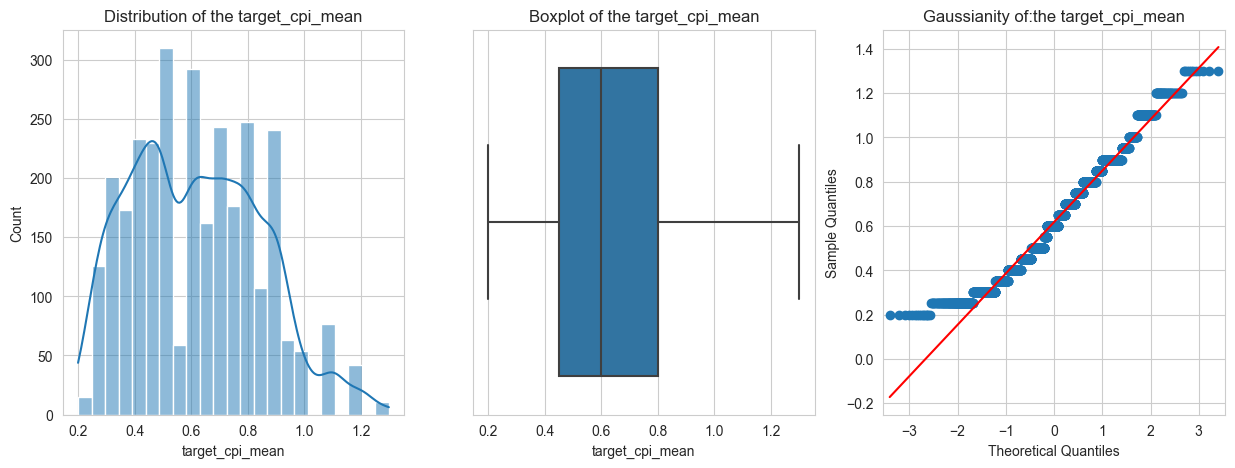

In [72]:
variable = 'target_cpi_mean'
y = df_merged[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = df_merged, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = df_merged, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianity of:the {variable}")
qqplot(df_merged[f"{variable}"],line='s',ax=ax[2]);

## Preprocessing the features with a Pipeline

### Feature Engineering

In [73]:
df_merged.head(5)

,date_dt,app_adam_id,campaign_id,campaign_name,currency,country_code,campaign_status,display_status,modification_time,serving_status,...,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,local_spend,taps,ttr,app_name,target_cpi_mean
0,2023-07-29,469337564,1420477419,CH_Reader_ASA_Discovery_EN-DE-FR_Q1,0,CH,ENABLED,RUNNING,2023-08-02 13:39:30.642,RUNNING,...,0,0.0,9,4,378,7.0861,19,0.0503,Adobe Acrobat Reader,0.50
1,2023-07-29,469337564,1420565694,CH_Reader_ASA_Generic_EN-DE-FR_Q1,0,CH,ENABLED,RUNNING,2023-08-02 13:39:33.519,RUNNING,...,0,0.0,1,1,67,2.9311,6,0.0896,Adobe Acrobat Reader,0.40
2,2023-07-29,469337564,1259027528,IN_Reader_ASA_Generic_EN_Q1,0,IN,ENABLED,RUNNING,2023-08-02 13:40:13.596,RUNNING,...,0,0.0,567,145,4258,233.6651,930,0.2184,Adobe Acrobat Reader,0.75
3,2023-07-29,469337564,1259038153,IN_Reader_ASA_Discovery_EN_Q1,0,IN,ENABLED,RUNNING,2023-08-02 13:40:10.180,RUNNING,...,0,2.0,360,113,16740,232.1870,1023,0.0611,Adobe Acrobat Reader,0.80
4,2023-07-29,469337564,1259106501,IN_Reader_ASA_Brand_EN_Q1,0,IN,ENABLED,RUNNING,2023-08-02 13:40:07.294,RUNNING,...,1,0.0,277,112,1124,75.8654,488,0.4342,Adobe Acrobat Reader,0.70


In [74]:
X = df_merged.copy()

In [75]:
# overspend
X["spend_vs_budget"] = X["daily_budget"] - X["local_spend"]
X["is_overspend"] = X.apply(lambda x: False if (x["local_spend"]/x["daily_budget"]) < 0.9 else True, axis=1)


In [76]:
# rolling aggregates
# List of key metrics for which we will create rolling aggregate features

rolling_metrics_sum = ['installs_redownloads',
                   'installs',
                   'taps',
                   'installs_new_downloads',
                   'impressions',
                   'local_spend',
                   'is_overspend',
                   'spend_vs_budget']

rolling_metrics_mean = ['installs_redownloads',
                   'installs',
                   'taps',
                   'installs_new_downloads',
                   'impressions',
                   'avg_cpa',
                   'avg_cpt',
                   'conversion_rate',
                   'ttr',
                   'local_spend',
                   'spend_vs_budget']


# create campaign id list
campaign_ids = X["campaign_id"].unique()

# loop over campaigns
df_list = []
for campaign in campaign_ids:
    df = X[X["campaign_id"]==campaign].copy()
    # sort df by date
    df.sort_values(by="date_dt", ascending=True, inplace=True)
    
    # Creating rolling aggregate features (sum or mean over the last 7 days) for each specific campaign
    for metric in rolling_metrics_mean:
        df[f'{metric}_rolling_mean_7d'] = df[metric].rolling(window=7).mean()
    
    for metric in rolling_metrics_sum:
        df[f'{metric}_rolling_sum_7d'] =df[metric].rolling(window=7).sum()

    df_list.append(df)
    
# re merge all datasets
X_fe = pd.concat(df_list, axis=0)

# drop all missing rows
X_fe.dropna(inplace=True)
X_fe.reset_index(drop=True, inplace=True)
    




In [77]:
# Calculating the correlation matrix
correlation_matrix = X_fe.corr()

# Selecting the correlation with the target variable 'target_cpi_mean'
target_correlation = correlation_matrix['target_cpi_mean'].sort_values(ascending=False)

# Displaying the correlation with the target variable
target_correlation.head(10), target_correlation.tail(10)

ValueError: could not convert string to float: 'CH_Reader_ASA_Discovery_EN-DE-FR_Q1'

The correlation analysis provides us with insights into the relationships between the features and the target variable `target_cpi_mean`. Here's a summary:

- **Positive Correlation**: Features like `installs_redownloads`, `installs`, `taps`, `installs_new_downloads`, and `country_code_IN` have positive correlations with the target variable.
- **Negative Correlation**: Features like `avg_cpt`, `avg_cpa`, and some specific `campaign_id` and `campaign_name` values have negative correlations with the target variable.
- **No Correlation**: Columns like `deleted`, `other`, `campaign_status_ENABLED`, and `display_status_RUNNING` have no correlation with the target and can be dropped.

In [78]:
# drop features
y = X_fe["target_cpi_mean"].copy()

X_fe = X_fe.drop(columns=['date_dt',
                   'modification_time',
                   'serving_status',
                   'deleted',
                   'other',
                   'app_adam_id',
                   'campaign_id',
                   'campaign_name',
                   'currency', 
                   'campaign_status',
                   'display_status',
                   'total_budget',
                   'target_cpi_mean']).copy()



### Numerical Pipeline

In [79]:
X_num = X_fe.select_dtypes(exclude = ['object', 'datetime', 'bool'])
X_num.head()

,daily_budget,avg_cpa,avg_cpt,conversion_rate,installs,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,...,local_spend_rolling_mean_7d,spend_vs_budget_rolling_mean_7d,installs_redownloads_rolling_sum_7d,installs_rolling_sum_7d,taps_rolling_sum_7d,installs_new_downloads_rolling_sum_7d,impressions_rolling_sum_7d,local_spend_rolling_sum_7d,is_overspend_rolling_sum_7d,spend_vs_budget_rolling_sum_7d
0,50.0,6.6203,5.2265,0.7895,15,0,0.0,8,7,260,...,28.600171,42.828400,42.0,101.0,157.0,59.0,4982.0,200.2012,2.0,299.7988
1,50.0,0.7845,0.4034,0.5143,18,0,0.0,11,7,733,...,29.311529,34.974186,43.0,103.0,166.0,60.0,4840.0,205.1807,2.0,244.8193
2,50.0,0.7578,0.3789,0.5000,7,0,0.0,5,2,535,...,28.907971,28.234886,40.0,95.0,160.0,55.0,4219.0,202.3558,2.0,197.6442
3,70.0,0.5451,0.3730,0.6842,13,0,0.0,9,4,378,...,28.978429,23.878714,38.0,94.0,163.0,56.0,4283.0,202.8490,2.0,167.1510
4,70.0,0.9076,0.4271,0.4706,8,0,0.0,4,4,386,...,29.236257,26.478029,37.0,94.0,167.0,57.0,4147.0,204.6538,2.0,185.3462


/var/folders/t5/2vtmnxs90kx7flyvm9lmcfzm0000gn/T/ipykernel_42154/470115386.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax =plt.subplots(1,3,figsize=(15,3))


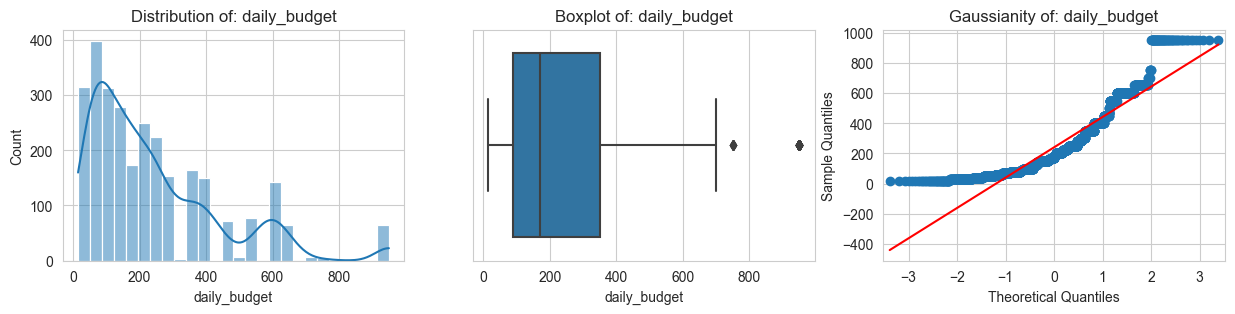

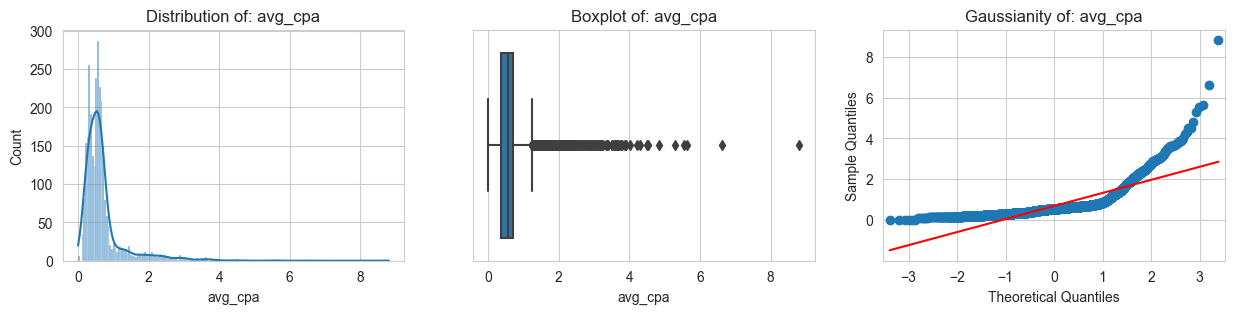

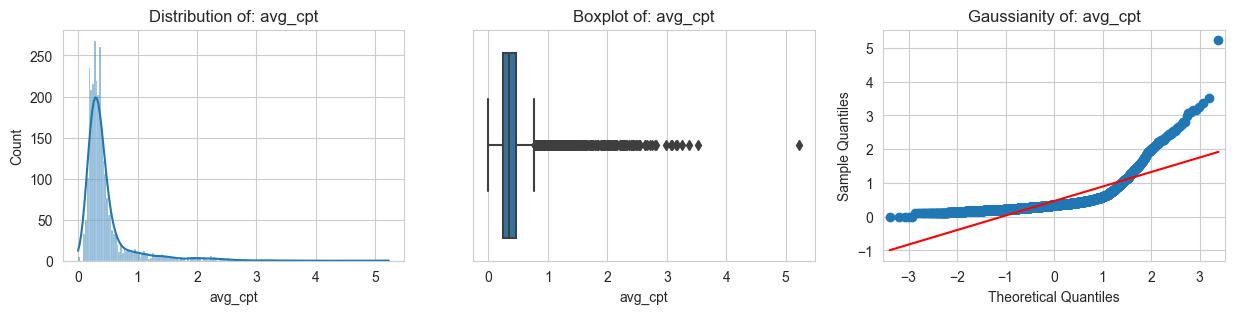

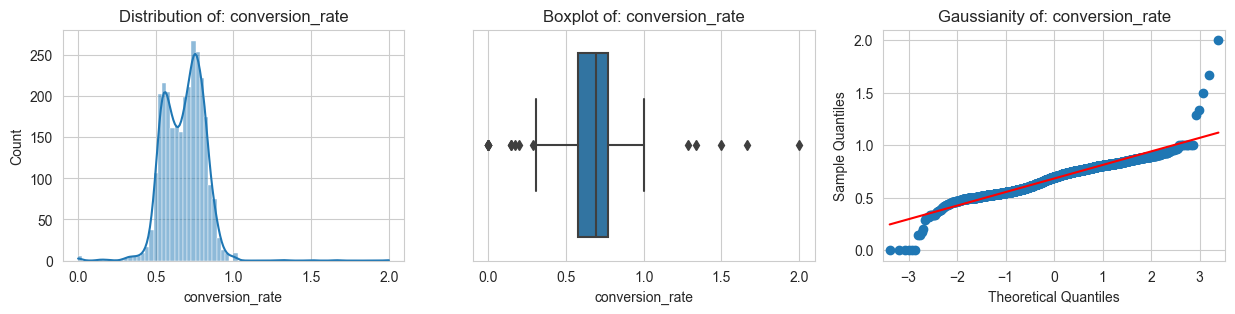

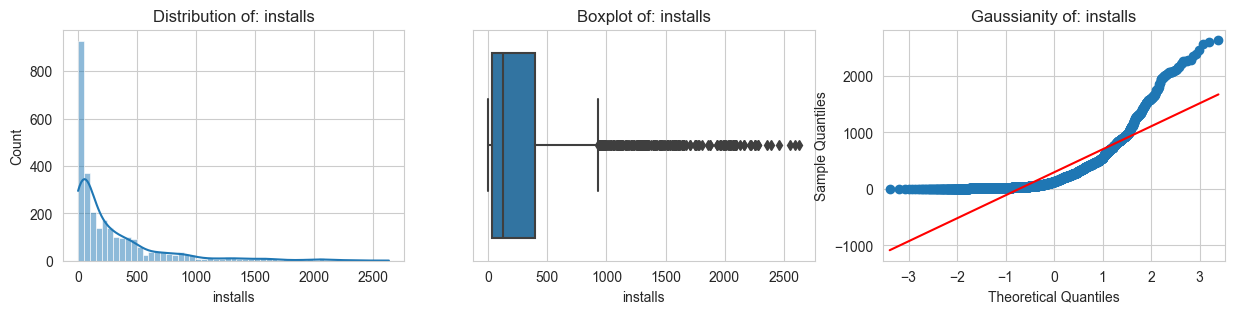

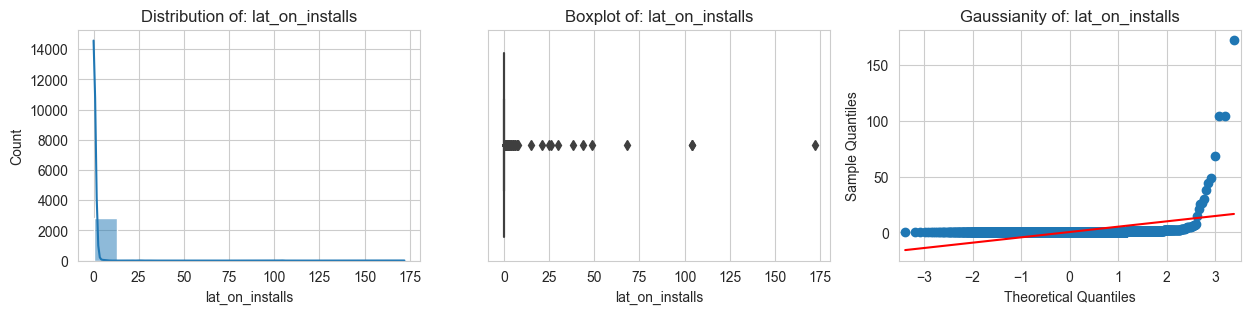

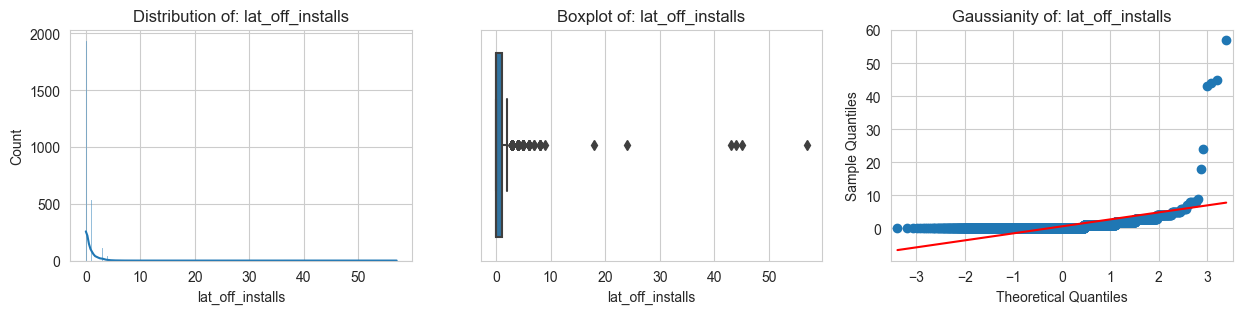

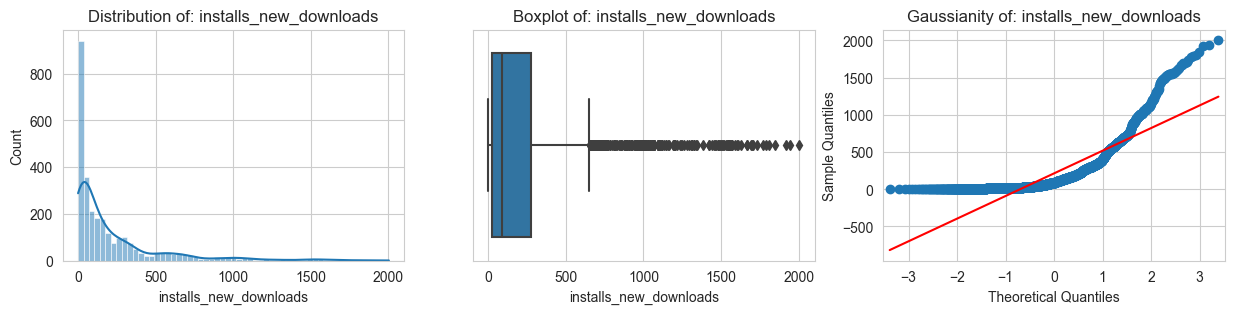

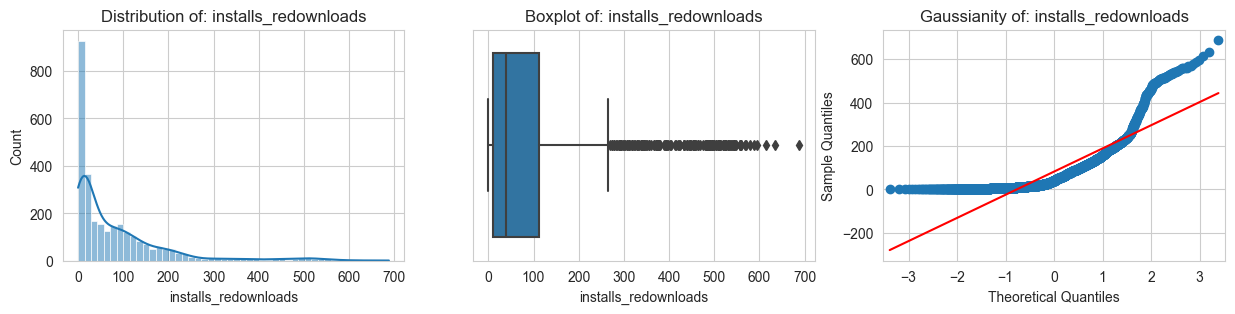

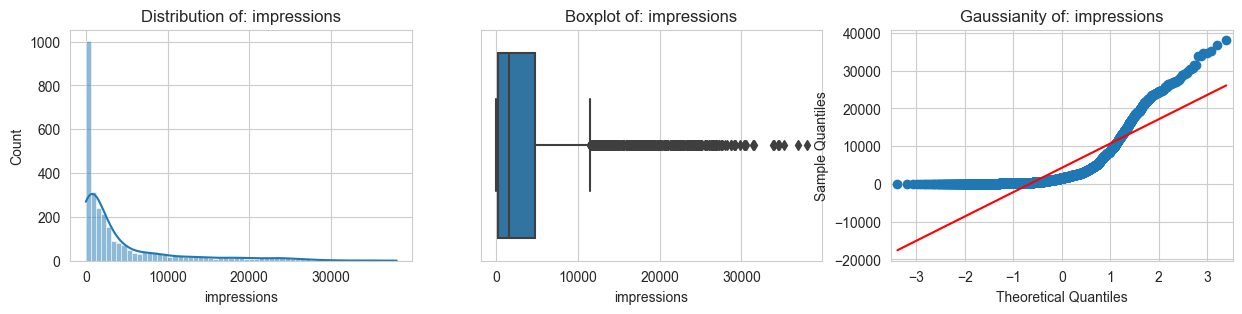

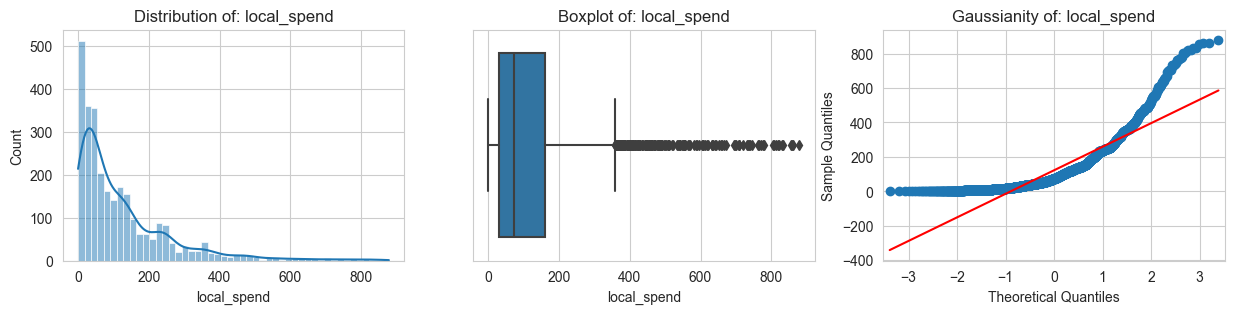

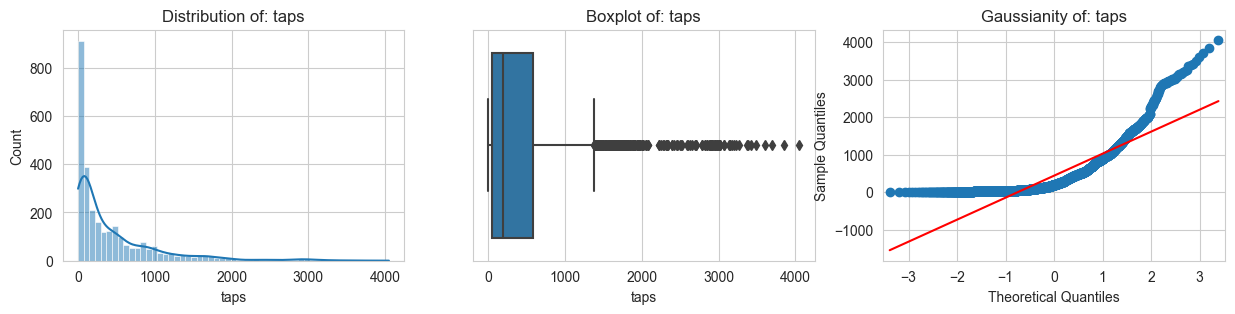

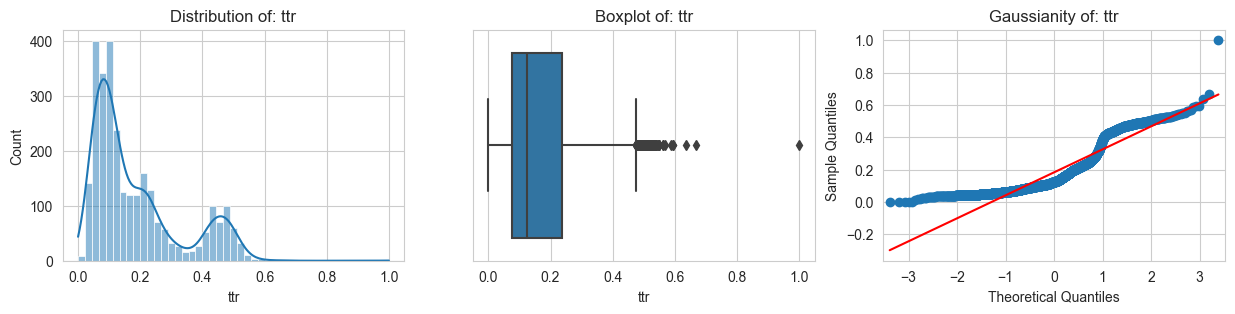

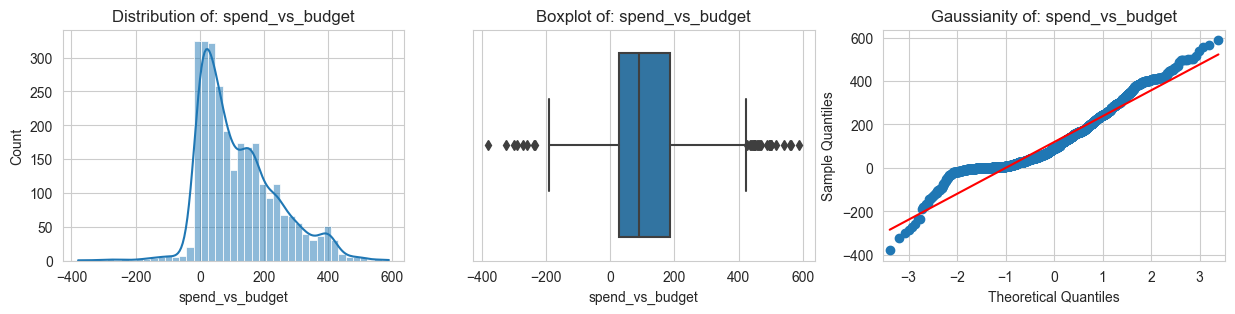

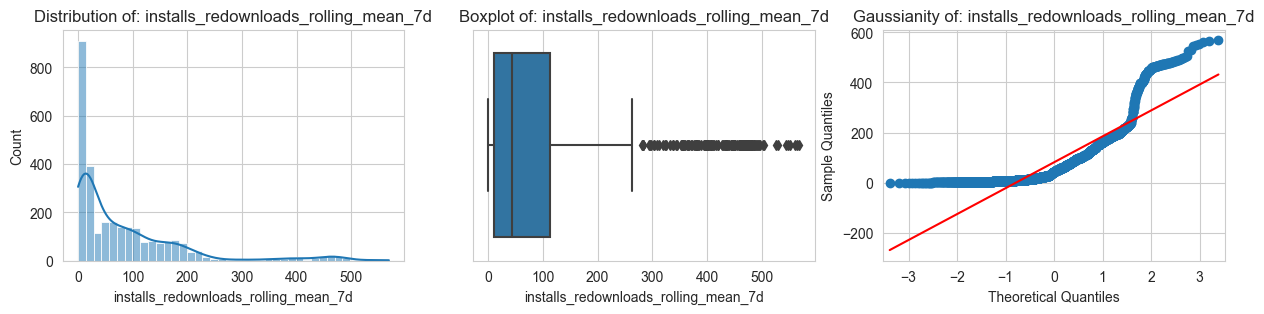

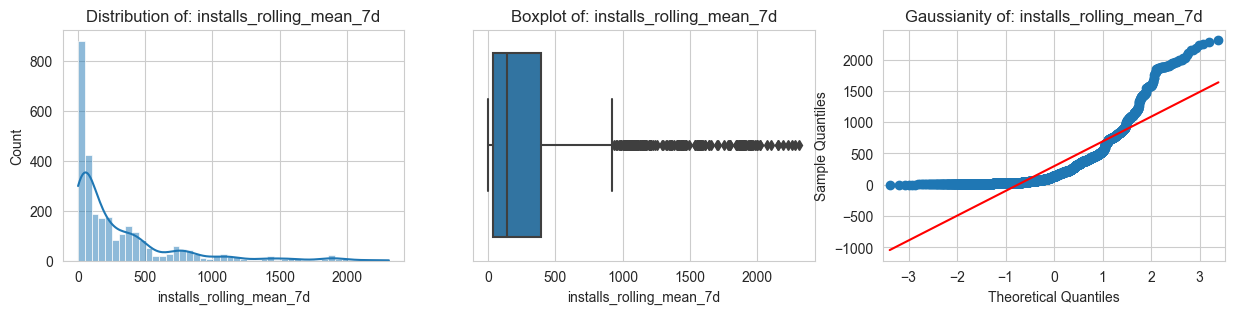

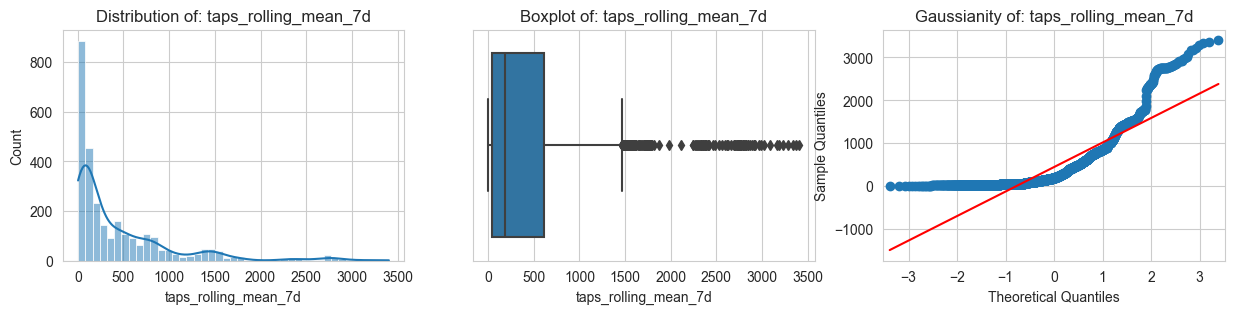

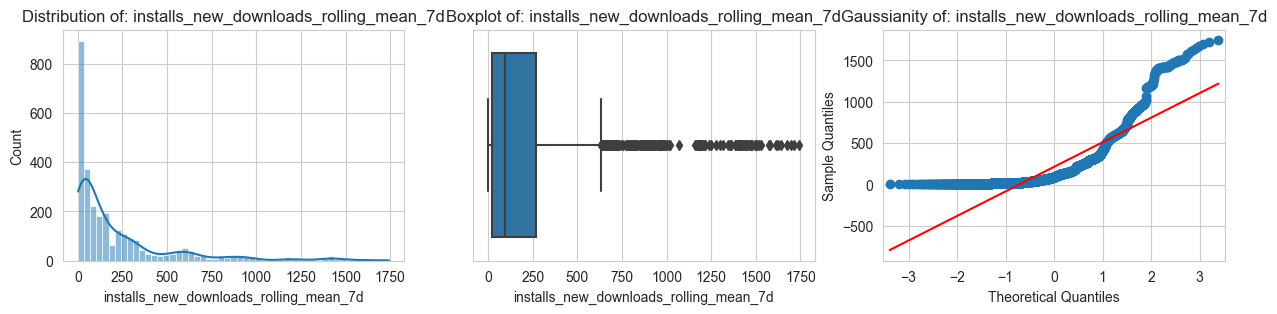

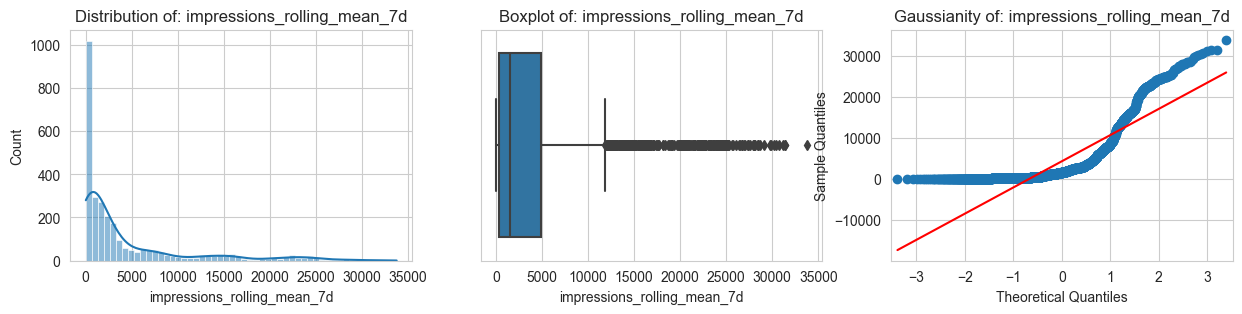

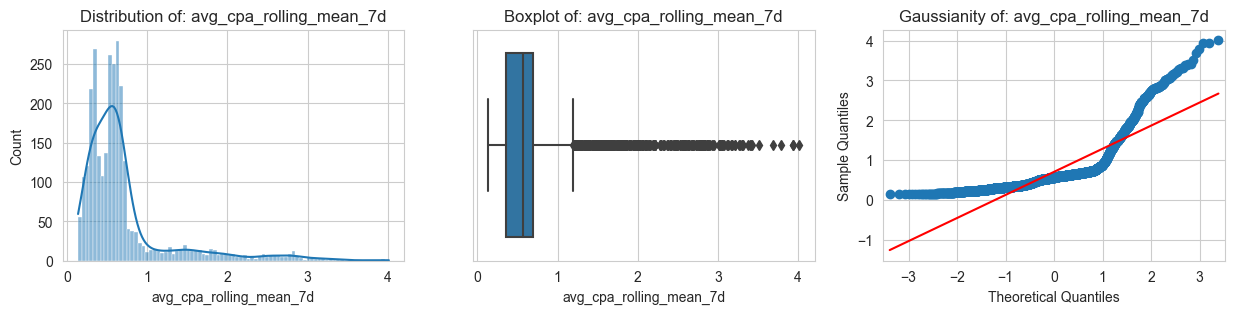

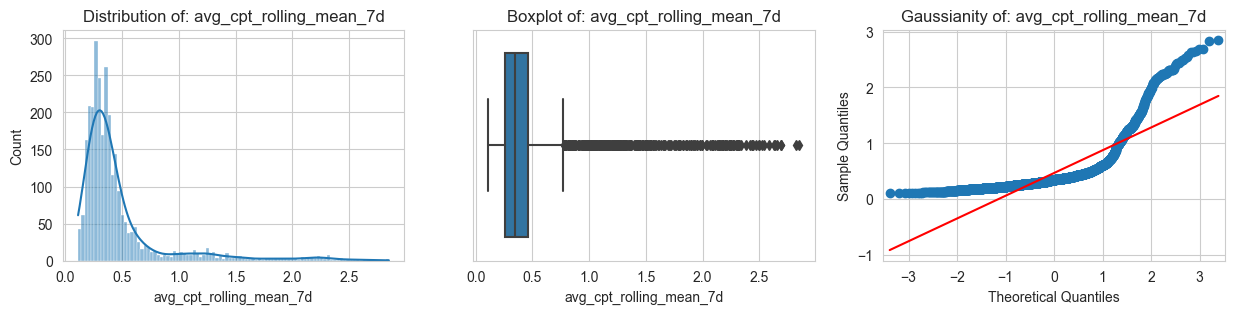

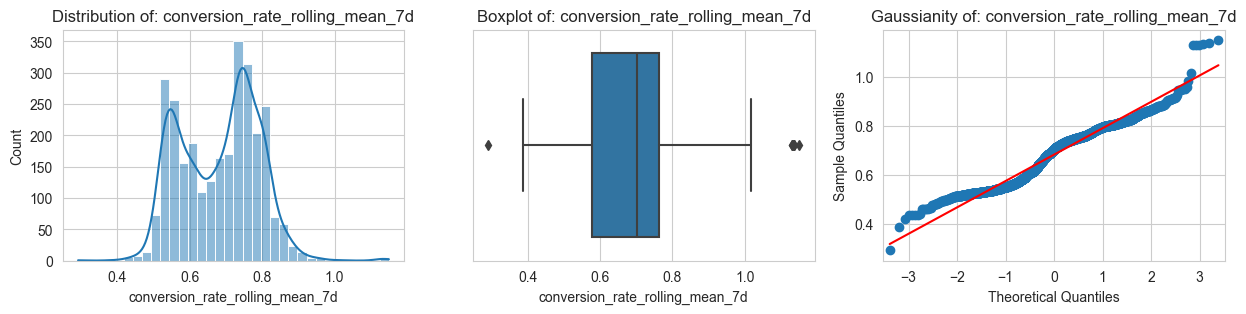

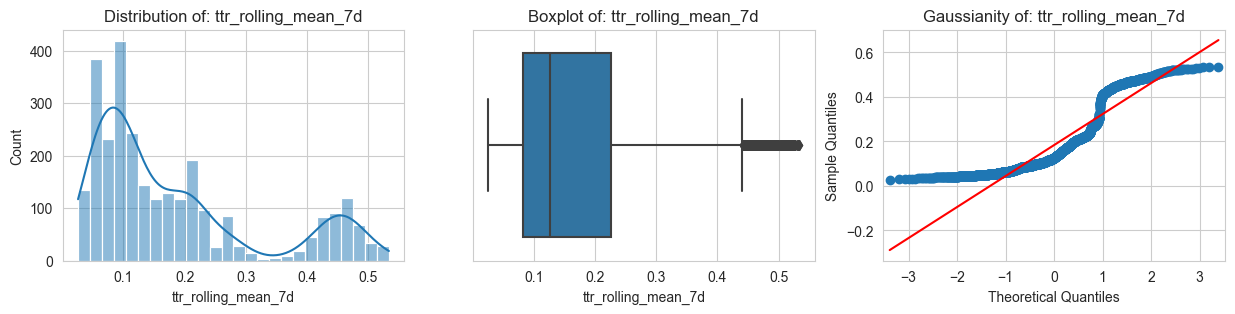

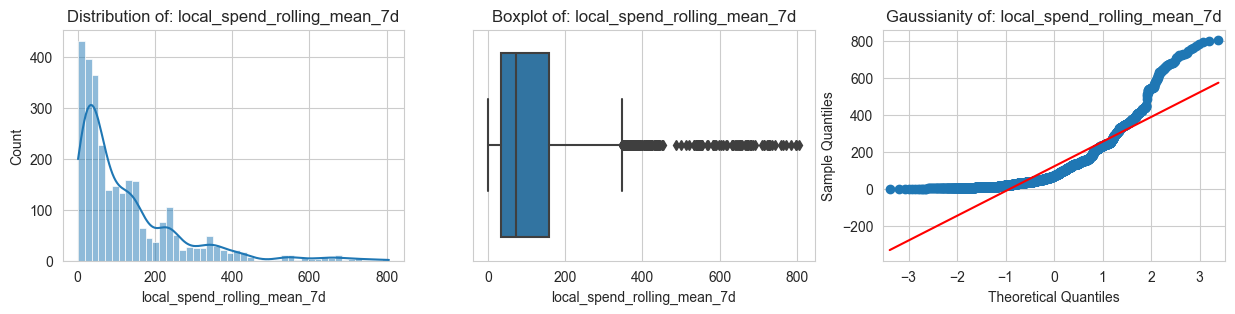

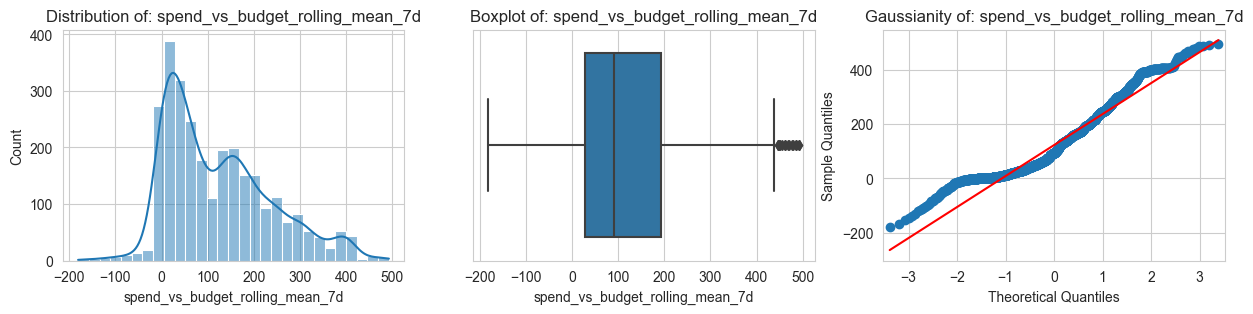

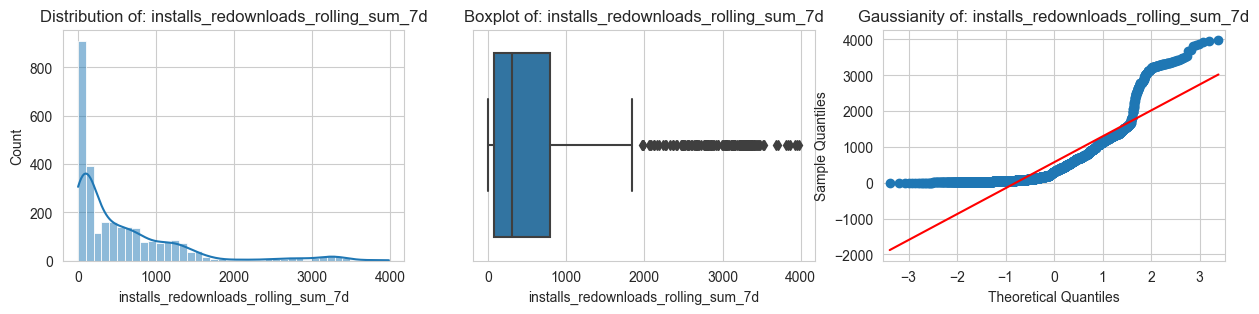

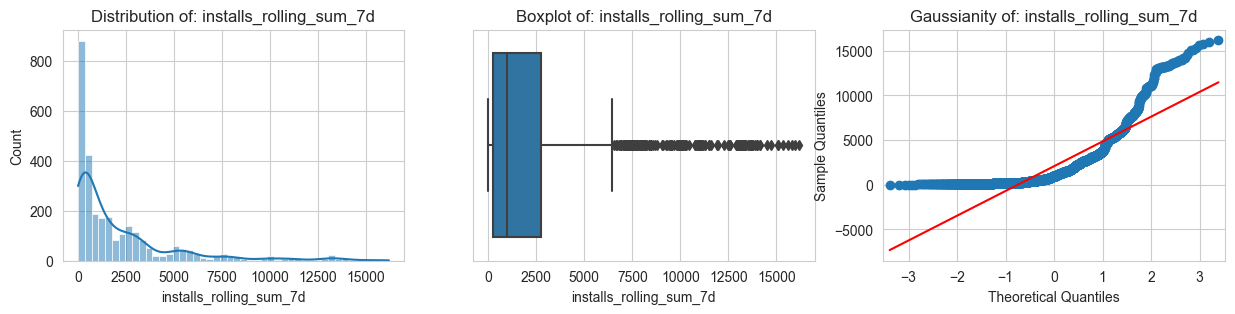

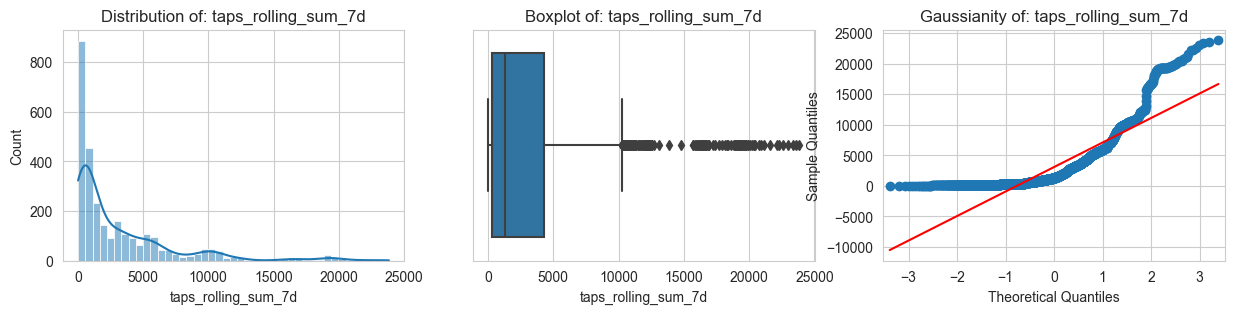

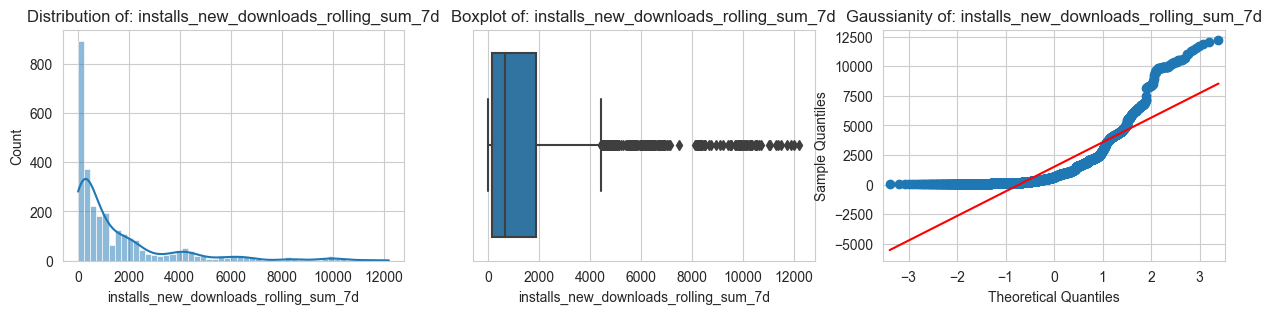

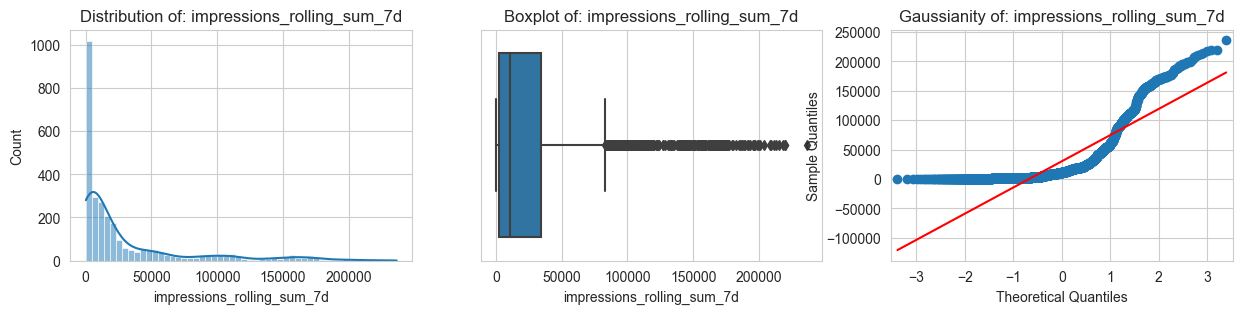

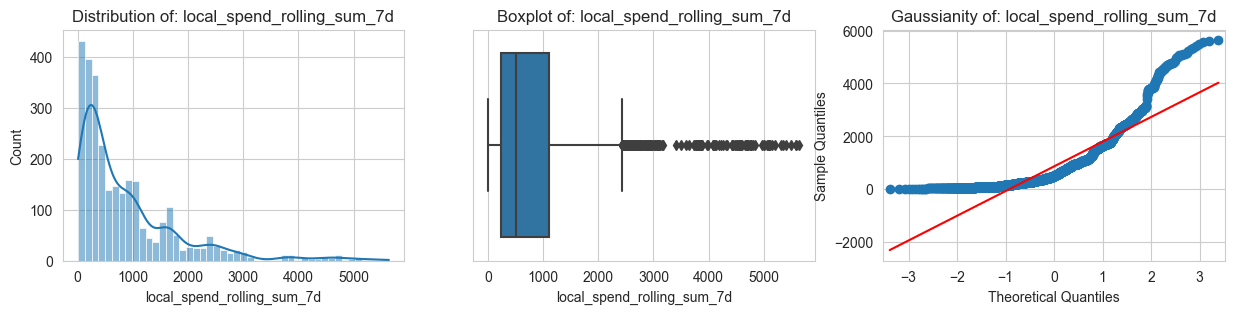

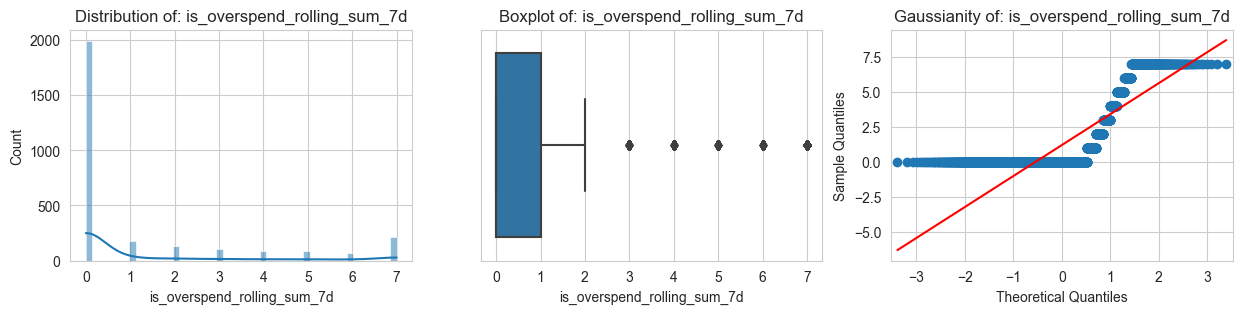

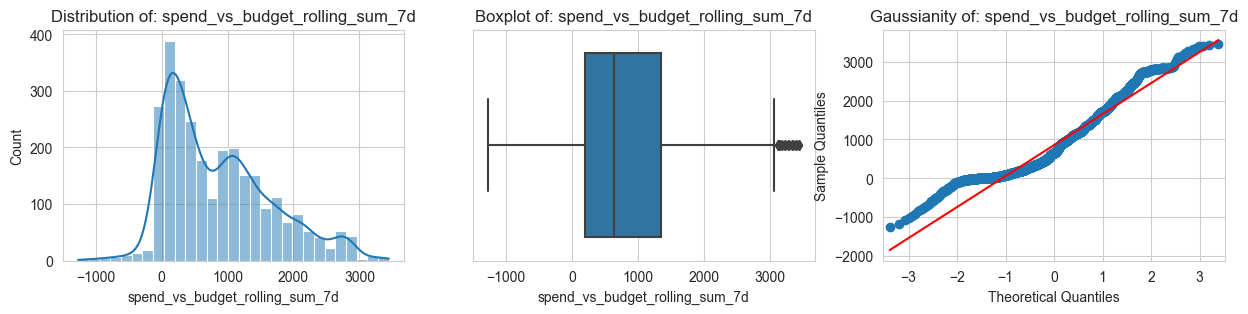

In [80]:
for numerical_feature in X_num.columns:
    
    # Creating three subplots per numerical_feature
    fig, ax =plt.subplots(1,3,figsize=(15,3))
    
    # Histogram to get an overview of the distribution of each numerical_feature
    ax[0].set_title(f"Distribution of: {numerical_feature}")
    sns.histplot(data = X_num, x = numerical_feature, kde=True, ax = ax[0])
    
    # Boxplot to detect outliers
    ax[1].set_title(f"Boxplot of: {numerical_feature}")
    sns.boxplot(data = X_num, x = numerical_feature, ax=ax[1])
    
    # Analyzing whether a feature is normally distributed or not
    ax[2].set_title(f"Gaussianity of: {numerical_feature}")
    qqplot(X_num[numerical_feature],line='s',ax=ax[2]);

In [81]:
features_robust = ['installs_redownloads_rolling_sum_7d',
                   'installs_rolling_sum_7d',
                   'taps_rolling_sum_7d',
                   'installs_new_downloads_rolling_sum_7d',
                   'impressions_rolling_sum_7d',
                   'local_spend_rolling_sum_7d',
                   'installs_redownloads_rolling_mean_7d',
                   'installs_rolling_mean_7d',
                   'taps_rolling_mean_7d',
                   'installs_new_downloads_rolling_mean_7d',
                   'impressions_rolling_mean_7d',
                   'avg_cpa_rolling_mean_7d',
                   'avg_cpt_rolling_mean_7d',
                   'local_spend_rolling_mean_7d',]


features_standard = ["conversion_rate",
                     "spend_vs_budget",
                     "spend_vs_budget_rolling_sum_7d",
                     "spend_vs_budget_rolling_mean_7d",
                     "conversion_rate_rolling_mean_7d",]

features_minmax = ['daily_budget',
                     'avg_cpa',
                     'avg_cpt',
                     'installs',
                     'lat_on_installs',
                     'lat_off_installs',
                     'installs_new_downloads',
                     'installs_redownloads',
                     'impressions',
                     'local_spend',
                     'taps',
                     'ttr',
                     'ttr_rolling_mean_7d',
                     'is_overspend_rolling_sum_7d']

In [82]:
# Checking what we didn't forget any numerical feature
X_num.shape[-1] == len(features_robust + features_standard + features_minmax)

True

In [83]:
class CustomSimpleImputer(SimpleImputer):
    def fit(self, X, *args, **kwargs):
        self.columns = X.columns
        return super().fit(X, *args, **kwargs) 
    
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.columns)
    
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.columns)

imputer_with_name = CustomSimpleImputer(strategy='median')

pd.DataFrame(imputer_with_name.fit_transform(X_num)).head()


,daily_budget,avg_cpa,avg_cpt,conversion_rate,installs,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,impressions,...,local_spend_rolling_mean_7d,spend_vs_budget_rolling_mean_7d,installs_redownloads_rolling_sum_7d,installs_rolling_sum_7d,taps_rolling_sum_7d,installs_new_downloads_rolling_sum_7d,impressions_rolling_sum_7d,local_spend_rolling_sum_7d,is_overspend_rolling_sum_7d,spend_vs_budget_rolling_sum_7d
0,50.0,6.6203,5.2265,0.7895,15.0,0.0,0.0,8.0,7.0,260.0,...,28.600171,42.828400,42.0,101.0,157.0,59.0,4982.0,200.2012,2.0,299.7988
1,50.0,0.7845,0.4034,0.5143,18.0,0.0,0.0,11.0,7.0,733.0,...,29.311529,34.974186,43.0,103.0,166.0,60.0,4840.0,205.1807,2.0,244.8193
2,50.0,0.7578,0.3789,0.5000,7.0,0.0,0.0,5.0,2.0,535.0,...,28.907971,28.234886,40.0,95.0,160.0,55.0,4219.0,202.3558,2.0,197.6442
3,70.0,0.5451,0.3730,0.6842,13.0,0.0,0.0,9.0,4.0,378.0,...,28.978429,23.878714,38.0,94.0,163.0,56.0,4283.0,202.8490,2.0,167.1510
4,70.0,0.9076,0.4271,0.4706,8.0,0.0,0.0,4.0,4.0,386.0,...,29.236257,26.478029,37.0,94.0,167.0,57.0,4147.0,204.6538,2.0,185.3462


In [84]:
# -------------------------------------- #
#   CUSTOMIZED COLUMN TRANSFORMER       #
# -------------------------------------- #
# Nice class to keep the columns'names before fitting a model

class CustomColumnTransformer(ColumnTransformer):
    
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs)
    
    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().transform(X, *args, **kwargs), columns=self.get_feature_names_out())
    
    def fit_transform(self, X, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(X, *args, **kwargs), columns=self.get_feature_names_out())

In [85]:
num_transformer = make_pipeline(
                    CustomColumnTransformer(
                                [
                                    ("robust_scaler", RobustScaler(), features_robust),
                                    ("standard_scaler", StandardScaler(), features_standard),
                                    ("minmax_scaler", MinMaxScaler(), features_minmax)
                                ])
                )

num_transformer.fit(X_num)
num_transformer.transform(X_num)
num_transformer.fit_transform(X_num)

,robust_scaler__installs_redownloads_rolling_sum_7d,robust_scaler__installs_rolling_sum_7d,robust_scaler__taps_rolling_sum_7d,robust_scaler__installs_new_downloads_rolling_sum_7d,robust_scaler__impressions_rolling_sum_7d,robust_scaler__local_spend_rolling_sum_7d,robust_scaler__installs_redownloads_rolling_mean_7d,robust_scaler__installs_rolling_mean_7d,robust_scaler__taps_rolling_mean_7d,robust_scaler__installs_new_downloads_rolling_mean_7d,...,minmax_scaler__lat_on_installs,minmax_scaler__lat_off_installs,minmax_scaler__installs_new_downloads,minmax_scaler__installs_redownloads,minmax_scaler__impressions,minmax_scaler__local_spend,minmax_scaler__taps,minmax_scaler__ttr,minmax_scaler__ttr_rolling_mean_7d,minmax_scaler__is_overspend_rolling_sum_7d
0,-0.371508,-0.344182,-0.284597,-0.344320,-0.183937,-0.345267,-0.371508,-0.344182,-0.284597,-0.344320,...,0.000000,0.000000,0.003992,0.010174,0.006811,0.112963,0.004691,0.0731,0.022702,0.285714
1,-0.370112,-0.343386,-0.282326,-0.343732,-0.188332,-0.339607,-0.370112,-0.343386,-0.282326,-0.343732,...,0.000000,0.000000,0.005489,0.010174,0.019248,0.016063,0.008642,0.0477,0.027772,0.285714
2,-0.374302,-0.346571,-0.283840,-0.346675,-0.207554,-0.342818,-0.374302,-0.346571,-0.283840,-0.346675,...,0.000000,0.000000,0.002495,0.002907,0.014042,0.006035,0.003457,0.0262,0.030279,0.285714
3,-0.377095,-0.346969,-0.283083,-0.346086,-0.205573,-0.342257,-0.377095,-0.346969,-0.283083,-0.346086,...,0.000000,0.000000,0.004491,0.005814,0.009913,0.008061,0.004691,0.0503,0.030082,0.285714
4,-0.378492,-0.346969,-0.282074,-0.345497,-0.209783,-0.340206,-0.378492,-0.346969,-0.282074,-0.345497,...,0.000000,0.000000,0.001996,0.005814,0.010124,0.008259,0.004198,0.0440,0.035462,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,-0.322626,-0.297203,-0.234641,-0.295468,-0.254912,-0.373995,-0.322626,-0.297203,-0.234641,-0.295468,...,0.000000,0.000000,0.012974,0.011628,0.010518,0.022744,0.012593,0.1272,0.213588,0.428571
2854,-0.321229,-0.296407,-0.233632,-0.294879,-0.250888,-0.389196,-0.321229,-0.296407,-0.233632,-0.294879,...,0.000000,0.000000,0.006986,0.007267,0.008257,0.015419,0.007901,0.1016,0.199561,0.428571
2855,-0.336592,-0.301583,-0.236912,-0.296057,-0.252590,-0.396895,-0.336592,-0.301583,-0.236912,-0.296057,...,0.000000,0.000000,0.011976,0.005814,0.010124,0.024048,0.012346,0.1295,0.195786,0.285714
2856,-0.347765,-0.307953,-0.242967,-0.300765,-0.252962,-0.412092,-0.347765,-0.307953,-0.242967,-0.300765,...,0.000000,0.000000,0.004990,0.007267,0.009019,0.013788,0.006420,0.0756,0.177534,0.285714


In [86]:
num_transformer

Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('robust_scaler',
                                                        RobustScaler(),
                                                        ['installs_redownloads_rolling_sum_7d',
                                                         'installs_rolling_sum_7d',
                                                         'taps_rolling_sum_7d',
                                                         'installs_new_downloads_rolling_sum_7d',
                                                         'impressions_rolling_sum_7d',
                                                         'local_spend_rolling_sum_7d',
                                                         'installs_redownloads_rolling_mean_7d',
                                                         'installs_rol...
                                                         'spend_vs_budget_rolling_sum_7d',
                                                         'spend_vs_budget_rolling_mean_7d',
                                                         'conversion_rate_rolling_mean_7d']),
                                                       ('minmax_scaler',
                                                        MinMaxScaler(),
                                                        ['daily_budget',
                                                         'avg_cpa', 'avg_cpt',
                                                         'installs',
                                                         'lat_on_installs',
                                                         'lat_off_installs',
                                                         'installs_new_downloads',
                                                         'installs_redownloads',
                                                         'impressions',
                                                         'local_spend', 'taps',
                                                         'ttr',
                                                         'ttr_rolling_mean_7d',
                                                         'is_overspend_rolling_sum_7d'])]))])

### Categorical Pipeline

In [87]:
X_cat = X_fe.select_dtypes(include=['object', 'bool'])
X_cat.head()

,country_code,app_name,is_overspend
0,CH,Adobe Acrobat Reader,True
1,CH,Adobe Acrobat Reader,False
2,CH,Adobe Acrobat Reader,False
3,CH,Adobe Acrobat Reader,False
4,CH,Adobe Acrobat Reader,False


In [88]:
cat_features = list(X_cat.columns)
cat_features

['country_code', 'app_name', 'is_overspend']

In [89]:
unique_occurences = {cat_feature:
                                 len(X_cat[cat_feature].value_counts()) 
                                 for cat_feature in X_cat.columns}

unique_occurences = pd.DataFrame.from_dict(unique_occurences,
                                                       orient = "index",
                                                       columns = ["unique_occurences"])

unique_occurences = unique_occurences.sort_values(by = "unique_occurences",
                                                  ascending = False)

In [90]:
unique_occurences

,unique_occurences
country_code,8
app_name,2
is_overspend,2


In [91]:
# cutstom OHE that passes column names

class CustomOHE(OneHotEncoder):
    def fit(self, *args, **kwargs):
        return super().fit(*args, **kwargs) 
    
    def transform(self,*args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names_out())

    def fit_transform(self,*args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names_out())

cat_transformer = make_pipeline(
                    CustomOHE(sparse=False,
                              handle_unknown="ignore",
                              drop='if_binary')
                )
X_cat_encoded = pd.DataFrame(cat_transformer.fit_transform(X_cat))
X_cat_encoded.shape

(2858, 10)

In [92]:
X_cat_encoded

,country_code_AR,country_code_CH,country_code_HK,country_code_IN,country_code_IT,country_code_JP,country_code_KR,country_code_MX,app_name_Adobe Scan,is_overspend_True
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2853,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2854,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2855,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2856,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Full Preprocessor

In [93]:
preprocessor = make_pipeline(
                CustomColumnTransformer([
                    ("num_transformer", num_transformer, make_column_selector(dtype_include = ["float64","int64"])),
                    ("cat_transformer", cat_transformer, make_column_selector(dtype_include = ["object", 'bool']))
                    ])
                )

preprocessor

Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_transformer',
                                                        Pipeline(steps=[('customcolumntransformer',
                                                                         CustomColumnTransformer(transformers=[('robust_scaler',
                                                                                                                RobustScaler(),
                                                                                                                ['installs_redownloads_rolling_sum_7d',
                                                                                                                 'installs_rolling_sum_7d',
                                                                                                                 'taps_rolling_sum_7d',
                                                                                                                 'installs_new_downloads_rolling_sum_7d',
                                                                                                                 'impressio...
                                                                                                                 'taps',
                                                                                                                 'ttr',
                                                                                                                 'ttr_rolling_mean_7d',
                                                                                                                 'is_overspend_rolling_sum_7d'])]))]),
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x28a9aab00>),
                                                       ('cat_transformer',
                                                        Pipeline(steps=[('customohe',
                                                                         CustomOHE(drop='if_binary',
                                                                                   handle_unknown='ignore',
                                                                                   sparse=False))]),
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x28a9abb80>)]))])

In [94]:
fully_preprocessed_dataset = pd.DataFrame(preprocessor.fit_transform(X_fe))
fully_preprocessed_dataset

,num_transformer__robust_scaler__installs_redownloads_rolling_sum_7d,num_transformer__robust_scaler__installs_rolling_sum_7d,num_transformer__robust_scaler__taps_rolling_sum_7d,num_transformer__robust_scaler__installs_new_downloads_rolling_sum_7d,num_transformer__robust_scaler__impressions_rolling_sum_7d,num_transformer__robust_scaler__local_spend_rolling_sum_7d,num_transformer__robust_scaler__installs_redownloads_rolling_mean_7d,num_transformer__robust_scaler__installs_rolling_mean_7d,num_transformer__robust_scaler__taps_rolling_mean_7d,num_transformer__robust_scaler__installs_new_downloads_rolling_mean_7d,...,cat_transformer__country_code_AR,cat_transformer__country_code_CH,cat_transformer__country_code_HK,cat_transformer__country_code_IN,cat_transformer__country_code_IT,cat_transformer__country_code_JP,cat_transformer__country_code_KR,cat_transformer__country_code_MX,cat_transformer__app_name_Adobe Scan,cat_transformer__is_overspend_True
0,-0.371508,-0.344182,-0.284597,-0.344320,-0.183937,-0.345267,-0.371508,-0.344182,-0.284597,-0.344320,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.370112,-0.343386,-0.282326,-0.343732,-0.188332,-0.339607,-0.370112,-0.343386,-0.282326,-0.343732,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.374302,-0.346571,-0.283840,-0.346675,-0.207554,-0.342818,-0.374302,-0.346571,-0.283840,-0.346675,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.377095,-0.346969,-0.283083,-0.346086,-0.205573,-0.342257,-0.377095,-0.346969,-0.283083,-0.346086,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.378492,-0.346969,-0.282074,-0.345497,-0.209783,-0.340206,-0.378492,-0.346969,-0.282074,-0.345497,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,-0.322626,-0.297203,-0.234641,-0.295468,-0.254912,-0.373995,-0.322626,-0.297203,-0.234641,-0.295468,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2854,-0.321229,-0.296407,-0.233632,-0.294879,-0.250888,-0.389196,-0.321229,-0.296407,-0.233632,-0.294879,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2855,-0.336592,-0.301583,-0.236912,-0.296057,-0.252590,-0.396895,-0.336592,-0.301583,-0.236912,-0.296057,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2856,-0.347765,-0.307953,-0.242967,-0.300765,-0.252962,-0.412092,-0.347765,-0.307953,-0.242967,-0.300765,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Model Pipeline

In [95]:
def cpi_regression_models(regression_model, preprocessor):
    piped_regressor = make_pipeline(preprocessor, regression_model)
    return piped_regressor

In [96]:
from sklearn.neighbors import KNeighborsRegressor
cpi_regression_models(KNeighborsRegressor(), preprocessor)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('customcolumntransformer',
                                  CustomColumnTransformer(transformers=[('num_transformer',
                                                                         Pipeline(steps=[('customcolumntransformer',
                                                                                          CustomColumnTransformer(transformers=[('robust_scaler',
                                                                                                                                 RobustScaler(),
                                                                                                                                 ['installs_redownloads_rolling_sum_7d',
                                                                                                                                  'installs_rolling_sum_7d',
                                                                                                                                  'taps_rolling_sum_7d',
                                                                                                                                  'installs_new_download...
                                                                                                                                  'is_overspend_rolling_sum_7d'])]))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x28a9aab00>),
                                                                        ('cat_transformer',
                                                                         Pipeline(steps=[('customohe',
                                                                                          CustomOHE(drop='if_binary',
                                                                                                    handle_unknown='ignore',
                                                                                                    sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x28a9abb80>)]))])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [114]:
models = [LinearRegression(),
          Lasso(),
          ElasticNet(),
          SGDRegressor(),
          KNeighborsRegressor(),
          SVR(kernel = "linear"),
          SVR(kernel = "poly", degree = 2),
          SVR(kernel = "poly", degree = 3),          
          SVR(kernel = "rbf"),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
          GradientBoostingRegressor()
]

models_names = ["linear_regression",
                "lasso",
                "elastic_net",
                "sgd_regressor",
                "kneighbors_regressor",
                "SVR_linear",
                "SVR_poly_two",
                "SVR_poly_three",
                "SVR_rbf",                
                "decision_tree_regressor",
                "random_forest_regressor",
                "ada_boost_regressor",
                "gradient_boosting_regressor"
]

In [115]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_fe, y)
different_test_scores = []

for model_name, model in zip(models_names, models):

    temp_piped_regressor = cpi_regression_models(model, preprocessor)
    temp_piped_regressor.fit(X_train, y_train)
    different_test_scores.append(temp_piped_regressor.score(X_test, y_test))
    

comparing_regression_models_cpi = pd.DataFrame(list(zip(models_names, different_test_scores)),
                                                columns =['model_name', 'R2_score'])

round(comparing_regression_models_cpi.sort_values(by = "R2_score", ascending = False),2)

CPU times: user 3.79 s, sys: 3.03 s, total: 6.82 s
Wall time: 2.28 s


,model_name,R2_score
10,random_forest_regressor,0.92
4,kneighbors_regressor,0.87
9,decision_tree_regressor,0.82
12,gradient_boosting_regressor,0.82
8,SVR_rbf,0.78
7,SVR_poly_three,0.72
6,SVR_poly_two,0.69
11,ada_boost_regressor,0.63
0,linear_regression,0.52
5,SVR_linear,0.52


In [116]:
# Benchmark Model: Predicting the mean of target_cpi_mean from the training data
benchmark_pred = [y_train.mean()] * len(y_test)

## Fine tune Random Forest Regressor

In [117]:
# Scoring on multiple folds aka Cross Validation
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.3, random_state=42)

rf_model = cpi_regression_models(RandomForestRegressor(), preprocessor)

cv_scores = cross_val_score(rf_model,
                            X_train,
                            y_train,
                            scoring='r2',
                            cv=5)

# Calculate mean and standard deviation of the cross-validation scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_mean)
print("CV Score Standard Deviation:", cv_std)

Cross-Validation Scores: [0.90715232 0.91375132 0.89924182 0.90605109 0.92648439]
Mean CV Score: 0.9105361875379169
CV Score Standard Deviation: 0.009206646883470565


## Build RF Model

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.3, random_state=42)

rf_model = cpi_regression_models(RandomForestRegressor(), preprocessor)
rf_model.fit(X_train, y_train)
    
# Making predictions on the testing set
y_pred = rf_model.predict(X_test)
    
# Calculating evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2


(0.04201923076923083, 0.004053373834498838, 0.9273522798398143)

## Feature Importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled

In [119]:
# feature importance

permutation_score = permutation_importance(rf_model,
                                           X_train,
                                           y_train,
                                           n_repeats=100) # Perform Permutation

importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                        permutation_score.importances_mean)).T) # Unstack results

importance_df.columns=['feature','score decrease'] # Change column names

importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

,feature,score decrease
22,avg_cpa_rolling_mean_7d,0.328069
23,avg_cpt_rolling_mean_7d,0.289511
25,ttr_rolling_mean_7d,0.273286
32,impressions_rolling_sum_7d,0.266619
0,country_code,0.182299
24,conversion_rate_rolling_mean_7d,0.083373
1,daily_budget,0.079911
3,avg_cpt,0.060838
14,app_name,0.036607
16,is_overspend,0.001011


## Learning Curve

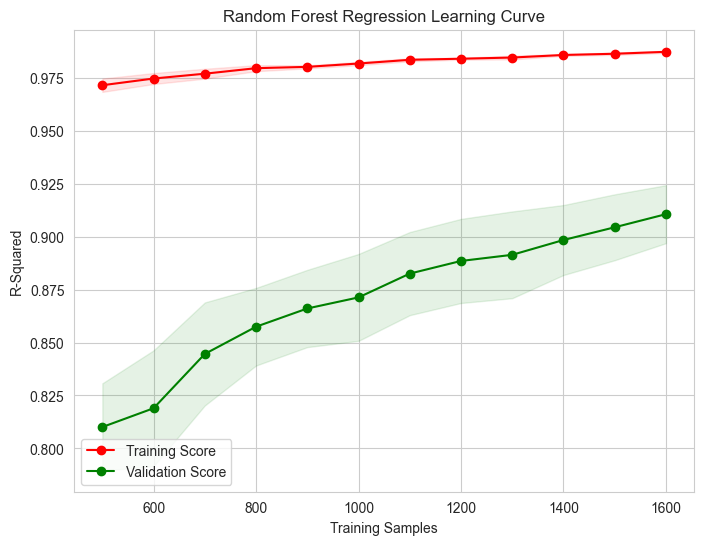

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y)

# Create the Random Forest Regression model with the best hyperparameters
rf_model = cpi_regression_models(RandomForestRegressor(), preprocessor)

# Create a learning curve using the best model
train_sizes, train_scores, valid_scores = learning_curve(
    rf_model,
    X_train,
    y_train,
    train_sizes=np.arange(500, 1700, 100),
    cv=5,
    scoring='r2',
    shuffle=True,
    random_state=42
)


# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Create the learning curve plot
plt.figure(figsize=(8, 6))
plt.title("Random Forest Regression Learning Curve")
plt.xlabel("Training Samples")
plt.ylabel("R-Squared")
plt.grid(True)

# Plot the training and validation scores with error bars
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, valid_mean, 'o-', color="g", label="Validation Score")

plt.legend()
plt.show()


## Reduce Feature space

In [121]:
features = importance_df.sort_values(by="score decrease", ascending = False).head(8)["feature"].values # Order by importance

In [122]:
X_fe_reduced = X_fe[list(features )].copy()

In [123]:
features_robust = [col for col in ['installs_redownloads_rolling_sum_7d',
                   'installs_rolling_sum_7d',
                   'taps_rolling_sum_7d',
                   'installs_new_downloads_rolling_sum_7d',
                   'impressions_rolling_sum_7d',
                   'local_spend_rolling_sum_7d',
                   'installs_redownloads_rolling_mean_7d',
                   'installs_rolling_mean_7d',
                   'taps_rolling_mean_7d',
                   'installs_new_downloads_rolling_mean_7d',
                   'impressions_rolling_mean_7d',
                   'avg_cpa_rolling_mean_7d',
                   'avg_cpt_rolling_mean_7d',
                   'local_spend_rolling_mean_7d',] if col in X_fe_reduced.columns]


features_standard = [col for col in ["conversion_rate",
                     "spend_vs_budget",
                     "spend_vs_budget_rolling_sum_7d",
                     "spend_vs_budget_rolling_mean_7d",
                     "conversion_rate_rolling_mean_7d",] if col in X_fe_reduced.columns]

features_minmax = [col for col in ['daily_budget',
                     'avg_cpa',
                     'avg_cpt',
                     'installs',
                     'lat_on_installs',
                     'lat_off_installs',
                     'installs_new_downloads',
                     'installs_redownloads',
                     'impressions',
                     'local_spend',
                     'taps',
                     'ttr',
                     'ttr_rolling_mean_7d',
                     'is_overspend_rolling_sum_7d']  if col in X_fe_reduced.columns]

In [124]:
num_transformer = make_pipeline(
                    CustomColumnTransformer(
                                [
                                    ("robust_scaler", RobustScaler(), features_robust),
                                    ("standard_scaler", StandardScaler(), features_standard),
                                    ("minmax_scaler", MinMaxScaler(), features_minmax)
                                ])
                )

num_transformer.fit(X_num)
num_transformer.transform(X_num)
num_transformer.fit_transform(X_num)

,robust_scaler__impressions_rolling_sum_7d,robust_scaler__avg_cpa_rolling_mean_7d,robust_scaler__avg_cpt_rolling_mean_7d,standard_scaler__conversion_rate_rolling_mean_7d,minmax_scaler__daily_budget,minmax_scaler__avg_cpt,minmax_scaler__ttr_rolling_mean_7d
0,-0.183937,3.790215,4.428038,-0.058501,0.037433,1.000000,0.022702
1,-0.188332,3.881177,4.464041,-0.192465,0.037433,0.077184,0.027772
2,-0.207554,3.973249,4.444858,-0.523731,0.037433,0.072496,0.030279
3,-0.205573,4.004907,4.417682,-0.776553,0.058824,0.071367,0.030082
4,-0.209783,4.101159,4.422825,-0.968423,0.058824,0.081718,0.035462
...,...,...,...,...,...,...,...
2853,-0.254912,0.891321,0.872166,-0.646962,0.016043,0.075002,0.213588
2854,-0.250888,0.519877,0.498167,-0.664585,0.016043,0.081049,0.199561
2855,-0.252590,0.551534,0.484058,-0.784901,0.016043,0.080895,0.195786
2856,-0.252962,0.545476,0.453754,-0.842012,0.016043,0.089199,0.177534


In [125]:
cat_transformer = make_pipeline(
                    CustomOHE(sparse=False,
                              handle_unknown="ignore",
                              drop='if_binary')
)

cat_transformer.fit_transform(X_cat)

,country_code_AR,country_code_CH,country_code_HK,country_code_IN,country_code_IT,country_code_JP,country_code_KR,country_code_MX,app_name_Adobe Scan,is_overspend_True
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2853,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2854,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2855,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2856,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [126]:
preprocessor = make_pipeline(
                CustomColumnTransformer([
                    ("num_transformer", num_transformer, make_column_selector(dtype_include = ["float64","int64"])),
                    ("cat_transformer", cat_transformer, make_column_selector(dtype_include = ["object", 'bool']))
                    ])
                )

preprocessor



Pipeline(steps=[('customcolumntransformer',
                 CustomColumnTransformer(transformers=[('num_transformer',
                                                        Pipeline(steps=[('customcolumntransformer',
                                                                         CustomColumnTransformer(transformers=[('robust_scaler',
                                                                                                                RobustScaler(),
                                                                                                                ['impressions_rolling_sum_7d',
                                                                                                                 'avg_cpa_rolling_mean_7d',
                                                                                                                 'avg_cpt_rolling_mean_7d']),
                                                                                                               ('standard_scaler',
                                                                                                                StandardScaler(),
                                                                                                                ['conversion_rate...
                                                                                                               ('minmax_scaler',
                                                                                                                MinMaxScaler(),
                                                                                                                ['daily_budget',
                                                                                                                 'avg_cpt',
                                                                                                                 'ttr_rolling_mean_7d'])]))]),
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x28c3f15a0>),
                                                       ('cat_transformer',
                                                        Pipeline(steps=[('customohe',
                                                                         CustomOHE(drop='if_binary',
                                                                                   handle_unknown='ignore',
                                                                                   sparse=False))]),
                                                        <sklearn.compose._column_transformer.make_column_selector object at 0x28c3f2950>)]))])

In [127]:
X_train

,country_code,daily_budget,avg_cpa,avg_cpt,conversion_rate,installs,lat_on_installs,lat_off_installs,installs_new_downloads,installs_redownloads,...,local_spend_rolling_mean_7d,spend_vs_budget_rolling_mean_7d,installs_redownloads_rolling_sum_7d,installs_rolling_sum_7d,taps_rolling_sum_7d,installs_new_downloads_rolling_sum_7d,impressions_rolling_sum_7d,local_spend_rolling_sum_7d,is_overspend_rolling_sum_7d,spend_vs_budget_rolling_sum_7d
1769,MX,200.0,0.6281,0.3958,0.6301,46,0,0.0,40,6,...,61.497914,138.502086,161.0,623.0,950.0,462.0,9146.0,430.4854,0.0,969.5146
1650,MX,350.0,0.6106,0.3158,0.5172,286,1,0.0,211,75,...,223.857443,126.142557,651.0,2491.0,4663.0,1840.0,101310.0,1567.0021,0.0,882.9979
189,IN,650.0,0.4594,0.2489,0.5419,672,0,2.0,519,153,...,348.314171,301.685829,1286.0,5488.0,9882.0,4202.0,155884.0,2438.1992,0.0,2111.8008
466,IT,75.0,0.5111,0.3503,0.6853,98,0,0.0,52,46,...,29.829486,45.170514,234.0,510.0,732.0,276.0,4172.0,208.8064,0.0,316.1936
1229,KR,60.0,0.3106,0.2547,0.8200,41,0,0.0,31,10,...,10.137729,54.147986,67.0,235.0,285.0,168.0,959.0,70.9641,0.0,379.0359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,IN,600.0,0.5007,0.3695,0.7379,715,0,2.0,570,145,...,309.777343,283.079800,1097.0,5182.0,7147.0,4085.0,42802.0,2168.4414,0.0,1981.5586
2417,IN,950.0,0.3507,0.2156,0.6147,1101,1,1.0,808,293,...,671.133400,278.866600,3248.0,13192.0,19508.0,9944.0,196349.0,4697.9338,0.0,1952.0662
1991,AR,60.0,0.8745,0.6360,0.7273,24,0,0.0,22,2,...,15.535857,44.464143,56.0,176.0,254.0,120.0,1080.0,108.7510,0.0,311.2490
586,IT,70.0,0.6073,0.3678,0.6056,86,0,0.0,66,20,...,42.151500,27.848500,111.0,495.0,825.0,384.0,8926.0,295.0605,0.0,194.9395


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X_fe_reduced, y)


rf_model = cpi_regression_models(RandomForestRegressor(),preprocessor)

rf_model.fit(X_train, y_train)
    
# Making predictions on the testing set
y_pred = rf_model.predict(X_test)
    
# Calculating evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2


(0.04083146853146854, 0.004258702447552446, 0.9233164940295385)

In [129]:
test_data = {'avg_cpa_rolling_mean_7d':[1,4],
             'avg_cpt_rolling_mean_7d':[2,7],
             'ttr_rolling_mean_7d': [0.4, 0],
             'country_code':["CH", "IN"],
             'conversion_rate_rolling_mean_7d':[0.7, 0],
             'app_name':["", ""],
             'avg_cpt':[0.8, 2],
             'daily_budget':[100, 70]
            }


In [130]:
rf_model.predict(pd.DataFrame(data=test_data))

KeyError: "['impressions_rolling_sum_7d'] not in index"

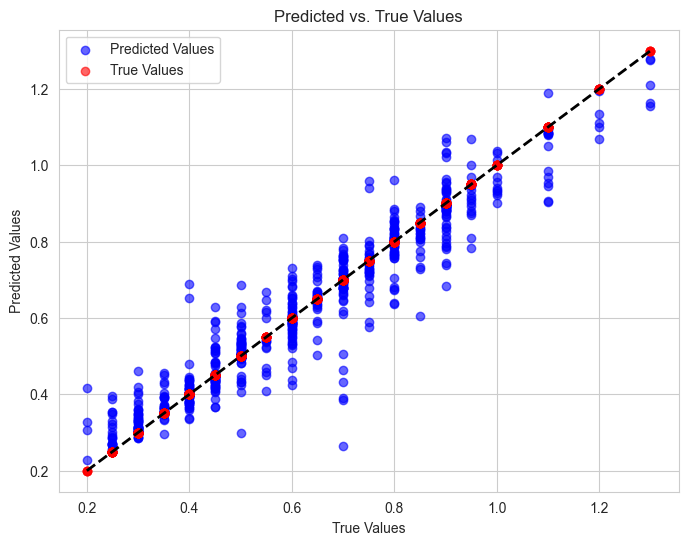

In [131]:
# Create a figure and axis for the plot
plt.figure(figsize=(8, 6))
plt.title("Predicted vs. True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

# Plot a diagonal line for reference (perfect prediction)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)

# Plot the actual values
plt.scatter(y_test, y_pred, color='b', alpha=0.6, label="Predicted Values")
plt.scatter(y_test, y_test, color='r', alpha=0.6, label="True Values")

plt.legend()
plt.grid(True)

# Show the plot
plt.show()
